# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>MIGUEL ÁNGEL FERNÁNDEZ ALONSO</mark>



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.7.20 installed
fastai version 2.7.18 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

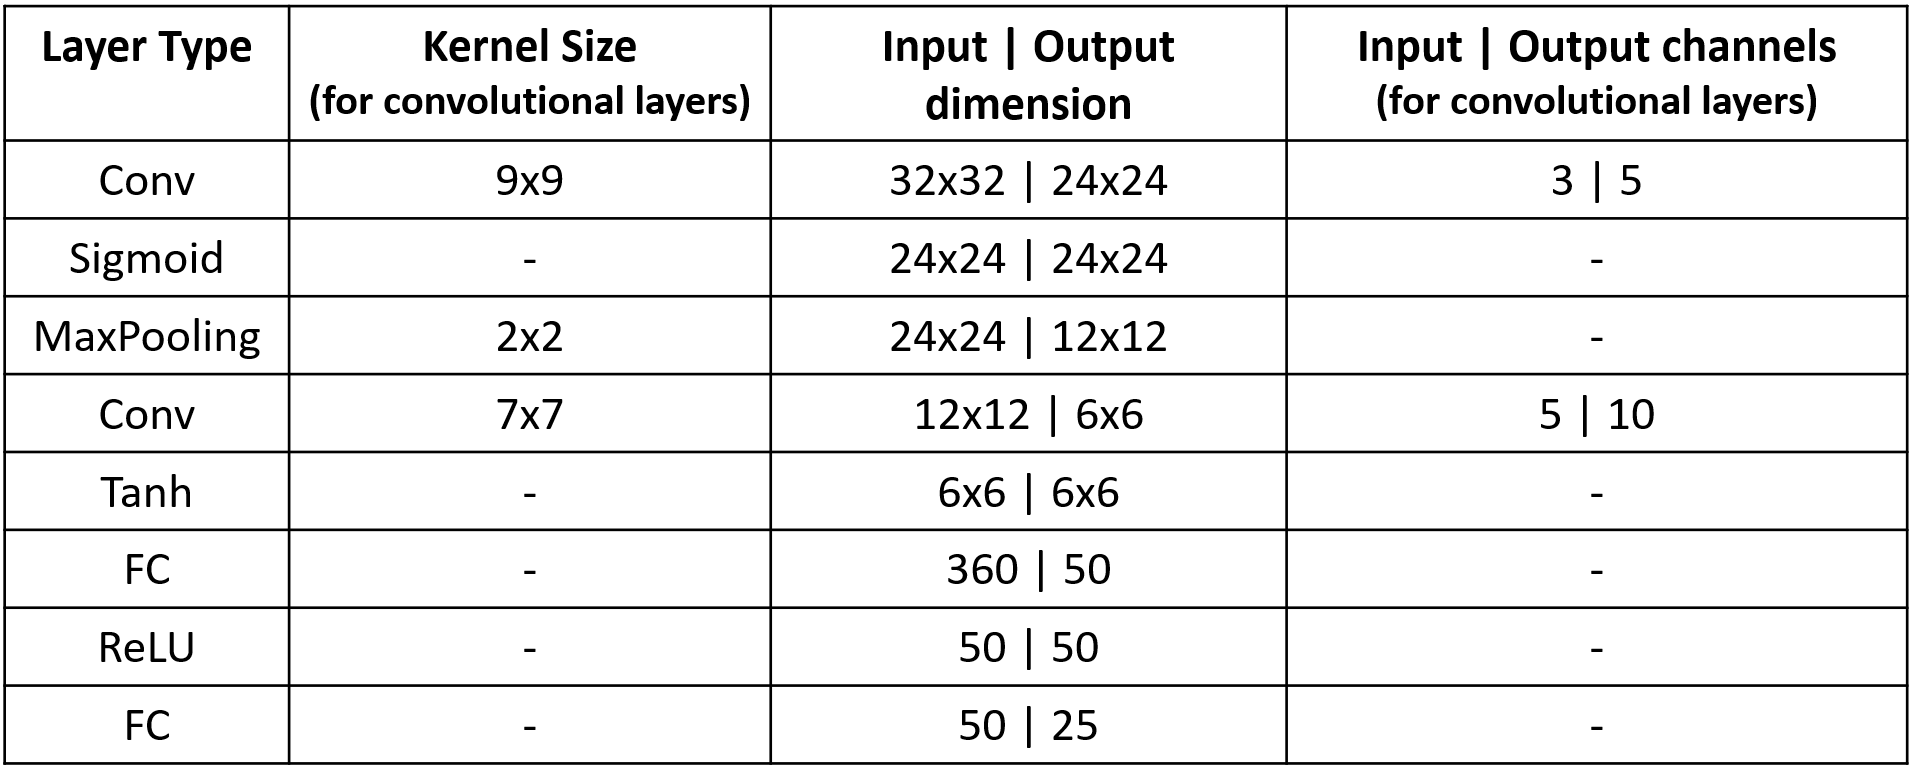

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/flowers'), Path('/root/.fastai/data/cifar100/tr

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [ ]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/trees ):  [Path('/root/.fastai/data/cifar100/train/trees/oak_tree'), Path('/root/.fastai/data/cifar100/train/trees/willow_tree'), Path('/root/.fastai/data/cifar100/train/trees/maple_tree'), Path('/root/.fastai/data/cifar100/train/trees/palm_tree'), Path('/root/.fastai/data/cifar100/train/trees/pine_tree')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de clases

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/reptiles
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/aquatic_mammals
/r

In [ ]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/reptiles


Ahora intentamos verificar si los hemos eliminado realmente.

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [ ]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/trees ):  [Path('/root/.fastai/data/cifar100/train/trees/oak_tree'), Path('/root/.fastai/data/cifar100/train/trees/willow_tree'), Path('/root/.fastai/data/cifar100/train/trees/maple_tree'), Path('/root/.fastai/data/cifar100/train/trees/palm_tree'), Path('/root/.fastai/data/cifar100/train/trees/pine_tree')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock.

## **1.1. Carga de Datos y Preparado**

Según se menciona en el enunciado, en este ejercicio utilizaremos una parte del conjunto de datos CIFAR100 (Canadian Institute for Advanced Research - 100 clases):

https://www.cs.toronto.edu/~kriz/cifar.html

Este conjunto incluye 60,000 imágenes a color de tamaño 32 x 32 x 3 (RGB), abarcando 100 clases diferentes (600 imágenes por clase, distribuidas equitativamente entre los conjuntos de entrenamiento y prueba). Las 100 clases están organizadas en 20 superclases, cada una de las cuales contiene cinco clases individuales. De las imágenes totales, 50,000 están destinadas a entrenamiento y 10,000 a pruebas. En este ejercicio, solo trabajaremos con 25 de las 100 clases, por lo que el conjunto de entrenamiento contiene 12,500 imágenes y el conjunto de prueba 2,500. Para la validación, se empleará el 10% del conjunto de entrenamiento.

Este es un conjunto de datos diseñado para tareas de clasificación de imágenes. Además, debido a que las imágenes son relativamente pequeñas (32 x 32 píxeles), plantea un desafío interesante para los modelos de aprendizaje profundo. CIFAR100 es ampliamente utilizado como referencia en el campo de la visión por computador.

### **1.1.1. DataBlock**

La función `DataBlock()` de FastAI es una herramienta que facilita la preparación y carga de datos para entrenar modelos de deep learning. Al definir un `DataBlock`, toda la lógica de preparación de datos se agrupa en un único lugar, lo que permite experimentar y ajustar el dataset de manera más sencilla sin necesidad de modificar el código en múltiples secciones.

Los principales parámetros de esta función (y los que usamos en nuestra definición de `DataBlock`) son los siguientes:

- `blocks`: Especifica los tipos de bloques de datos que se emplearán. En nuestro caso, utilizamos `(ImageBlock, CategoryBlock)`, lo cual indica que el modelo trabaja con imágenes como entrada y categorías como salida.

- `get_items`: Define cómo obtener los elementos que conformarán el conjunto de datos (en este caso, los archivos de imágenes). Para esto, usamos la función `get_image_files`, que devuelve una lista de archivos de imágenes.

- `splitter`: Determina cómo dividir el conjunto de datos en subconjuntos de entrenamiento y validación. Aquí utilizamos `RandomSplitter(valid_pct = 0.1, seed = 42)`, que realiza una división aleatoria reservando el 10% de los datos para validación, y emplea una semilla fija (`seed = 42`) para asegurar reproducibilidad (permitiendo que los resultados sean consistentes y verificables).

- `get_y`: Define cómo extraer las etiquetas correspondientes a los datos. En este caso, `parent_label` se usa para obtener las etiquetas a partir de las carpetas padres de los archivos de imágenes.

Para más detalles, se pueden consultar los siguientes enlaces de la documentación de FastAI:

[1] https://docs.fast.ai/data.block.html#general-api  
[2] https://docs.fast.ai/data.transforms.html#get_image_files  
[3] https://docs.fast.ai/data.transforms.html#parent_label  
[4] https://docs.fast.ai/tutorial.datablock.html

### **1.1.2. DataLoad**

En FastAI, el método `dataloaders()` permite crear un objeto `DataLoaders`, que representa los datos listos para ser usados en el entrenamiento y validación de modelos de deep learning. Este objeto incluye tanto el conjunto de entrenamiento como el de validación, junto con la lógica definida en el `DataBlock` para cargar y procesar los datos en lotes (batches) durante el entrenamiento. Esto facilita el uso eficiente de la GPU al cargar datos en paralelo mientras el modelo entrena. Analizando el código que usamos en este caso:

`train_val_CIFAR100dl = CIFAR100db.dataloaders(path/'train', bs=32)`

- `CIFAR100db` es el objeto `DataBlock` que configuramos previamente, el cual define cómo deben cargarse y procesarse los datos.

- `dataloaders()` es un método del `DataBlock` que recibe la ubicación de los datos `(path/'train')` y otros parámetros. En este caso, `bs=32` especifica el tamaño del lote en 32 imágenes (se ha elegido un tamaño de lote de 32, que es una potencia de dos, como buena práctica en entrenamiento de modelos).

Para obtener más información, se puede consultar la documentación de FastAI en los siguientes enlaces:

[5] https://docs.fast.ai/data.block.html#datablock.dataloaders  
[6] https://docs.fast.ai/data.load.html

In [ ]:
#Datablock
CIFAR100db = DataBlock(
                    blocks = (ImageBlock, CategoryBlock),                       #Tipo de bloque de datos (Entradas : Imágenes | Salidas: Categorías)
                    get_items = get_image_files,                                #Leemos todas las imágenes en las subcarpetas de 'path'
                    splitter = RandomSplitter(valid_pct = 0.1, seed = 42),      #Dividimos los datos de forma aleatoria entre entrenamiento (90%) y validación (10%)
                    get_y = parent_label                                        #Creamos las etiquetas
)


In [ ]:
#Definición del DataLoad para el conjunto de datos de entrenamiento y el conjunto de datos de validación
dls = CIFAR100db.dataloaders(path/'train', bs=32) #Creamos el DataLoad a partir del DataBlock en batches con un tamaño de 32 imágenes

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


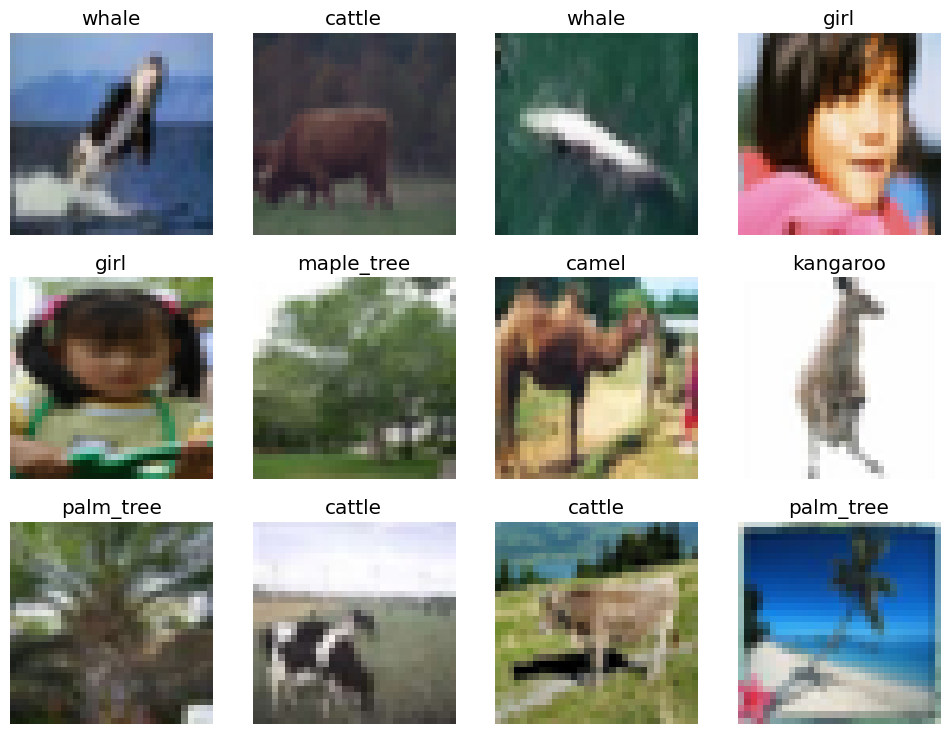

In [ ]:
#Mostramos un batch de imágenes del conjunto de entrenamiento
dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Example of training data


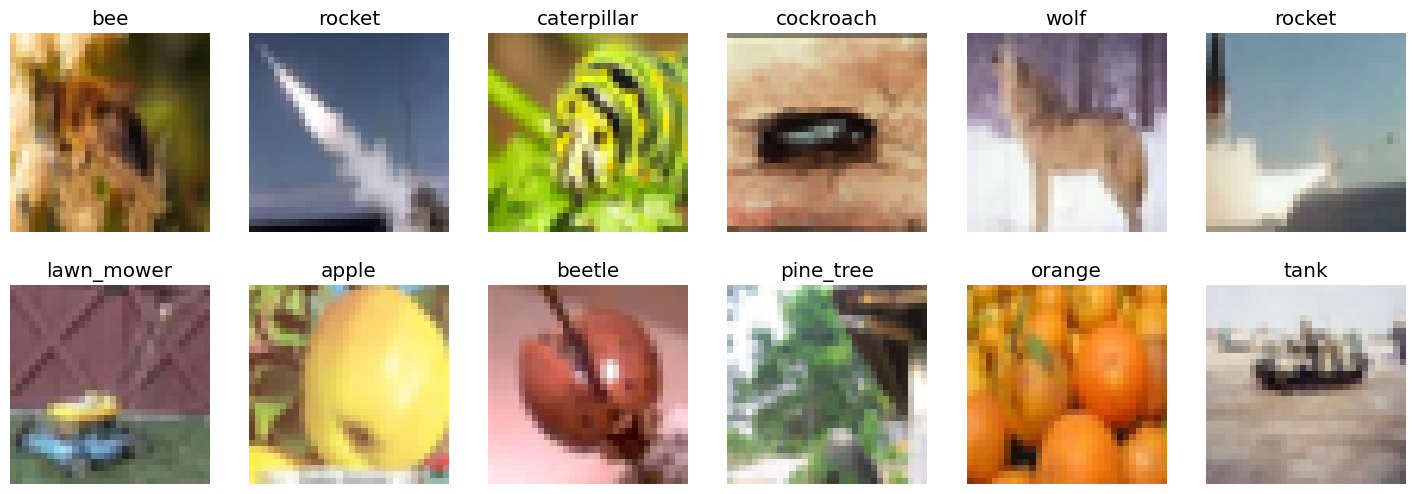

In [ ]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


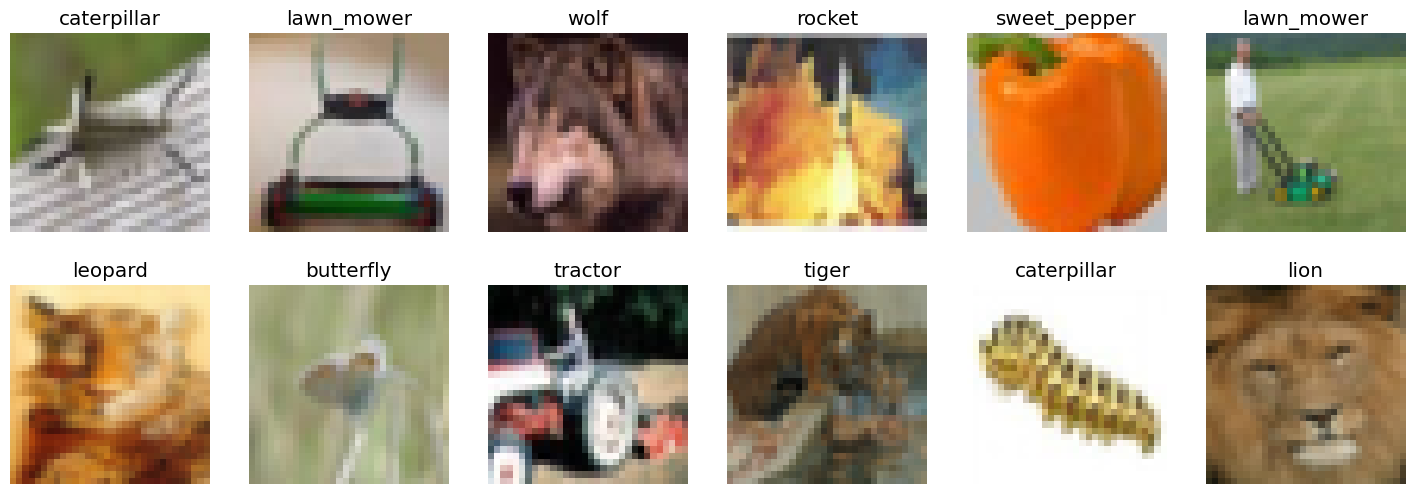

In [ ]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

Ahora procedemos con la creación y entrenamiento de la red BaseNet.

## **1.2. Definición del Modelo**

Tal como se detalla en el enunciado, nuestro modelo BaseNet está compuesto por dos bloques convolucionales (Conv + ReLU) a diferentes escalas (MaxPooling), y una sección final (head) formada por dos capas totalmente conectadas (fully-connected o FC, también conocidas como capas densas). Siguiendo la arquitectura especificada en la tabla del enunciado, la implementación del modelo BaseNet en FastAI se vería de la siguiente manera:

In [ ]:
#Creación del modelo
BaseNet = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size=(9,9)),            #Capa 1: Convolución
    nn.Sigmoid(),                                                               #Capa 2: Función de Activación Sigmoide
    nn.MaxPool2d(kernel_size=(2,2)),                                            #Capa 3: Agrupación Máxima MaxPooling 2x2
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),               #Capa 4: Convolución
    nn.Tanh(),                                                                  #Capa 5: Función Tangente
    nn.Flatten(),                                                               #Capa 6: Pasamos a tensor de una sola dimensión
    nn.Linear(in_features = 360, out_features=50),                              #Capa 7: Fully Connected
    nn.ReLU(),                                                                  #Capa 8: Función de Activación ReLU
    nn.Linear(in_features=50, out_features=25)                                  #Capa 9: Fully Connected 25 clases de salida
)



In [ ]:
BaseNet

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

Describimos cada capa del modelo:

### **1.2.1. Función `sequential()`**

En FastAI, la función `sequential()` se utiliza para construir un modelo de deep learning como una secuencia lineal de capas, donde la salida de una capa se convierte en la entrada de la siguiente. Esta función recibe una serie de capas como argumentos y las ejecuta en el orden indicado para formar el modelo completo.

Para más detalles, se puede consultar la documentación de FastAI y PyTorch:

[7] https://docs.fast.ai/layers.html#sequential-extensions  
[8] https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential

### **1.2.2. Módulo `nn`**

El prefijo `nn.` en `nn.Conv2d()` y en el resto de las capas de nuestro modelo BaseNet hace referencia al módulo `nn` (neural network) de PyTorch. Este módulo ofrece las herramientas y componentes fundamentales para crear y entrenar redes neuronales, incluyendo definiciones de capas, funciones de pérdida, optimizadores y otras utilidades necesarias para trabajar con redes neuronales.

Para más detalles, se puede consultar la documentación de PyTorch:

[9] https://pytorch.org/docs/stable/nn.html

### **1.2.3. Método `Conv2d()`**

El método `Conv2d()` en PyTorch (también disponible en FastAI, que es una API basada en PyTorch) representa una capa de convolución en una red neuronal convolucional (CNN). Esta capa permite extraer características espaciales de las imágenes de entrada mediante el uso de filtros convolucionales.

Los parámetros más comunes de este método son:

- `in_channels`: Número de canales de la imagen de entrada. Por ejemplo, una imagen en escala de grises tiene 1 canal, mientras que una imagen RGB tiene 3 canales (como en nuestro modelo BaseNet, donde la primera capa usa 3 canales).
  
- `out_channels`: Número de canales generados por la convolución, o cantidad de filtros aplicados, cada uno capturando diferentes características de la imagen.

- `kernel_size`: Tamaño del filtro o kernel. Puede ser un único valor (para un kernel cuadrado) o una tupla de dos valores para altura y anchura del kernel.

- `stride`: Cantidad de píxeles que el filtro avanza horizontal y verticalmente en cada paso. Si no se especifica, `stride` es 1, lo que significa que el filtro se mueve píxel a píxel.

- `padding`: Número de píxeles añadidos alrededor de la imagen antes de aplicar la convolución. Este relleno ayuda a mantener el tamaño de la imagen tras la convolución. Si no se especifica, el valor predeterminado es `padding = 0`.

- `bias`: Indica si se incluye un término de sesgo en la capa. El valor predeterminado es `bias = True`.

- `padding_mode`: Método de relleno si se usa `padding`, como 'zeros' o 'circular'. El valor predeterminado es `padding_mode = zeros`.

En nuestro modelo, el número de canales de entrada de la primera capa es 3, ya que las imágenes son RGB. La primera capa genera 4 canales, que sirven como entrada a la segunda capa de convolución, la cual produce 10 canales de salida. Si hubiera una tercera capa, esta tendría 10 canales de entrada, igual al número de canales de salida de la segunda capa, y así sucesivamente.

Para más información, se puede consultar la documentación de PyTorch:

[10] https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

### **1.2.4. Método `ReLU()`**

El método `ReLU()` en PyTorch representa la función de activación ReLU (Rectified Linear Unit), una función no lineal ampliamente utilizada en redes neuronales para introducir no linealidad en el modelo. Matemáticamente, ReLU se define como $( f(x) = max(0, x) $. Esto significa que si el valor de entrada $ x$ es positivo, la salida es $x$; si $x$ es negativo, la salida es cero.

La función ReLU es popular por su bajo coste computacional en comparación con funciones de activación más complejas, como la sigmoide o la tangente hiperbólica, ya que es más eficiente y rápida de calcular. Además, no sufre del problema del desvanecimiento del gradiente que afecta a funciones de activación saturadas.

Aplicada elemento a elemento en la salida de cada neurona, ReLU introduce no linealidad, permitiendo que la red capture patrones y características más complejas en los datos.

Para más detalles, se puede consultar la documentación de PyTorch:

[11] https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

### **1.2.5. Método `MaxPool2d()`**

El método `MaxPool2d()` en PyTorch representa una capa de agrupación máxima (max pooling) en dos dimensiones y es común en redes neuronales convolucionales para reducir la dimensionalidad espacial de las representaciones generadas por las capas anteriores. La operación de max pooling se aplica a regiones locales de la entrada, seleccionando el valor máximo de cada región, y se realiza por separado en cada canal de la entrada.

Los parámetros más comunes de este método son:

- `kernel_size`: Tamaño de la ventana sobre la que se aplica la operación de agrupación máxima. Puede ser un único valor (asumiendo una ventana cuadrada) o una tupla de dos valores para especificar la altura y anchura de la ventana.

- `stride`: Desplazamiento de la ventana en cada paso de la operación de agrupación, es decir, cuántos píxeles se mueve en cada dirección. Si no se especifica, `stride` toma el valor de `kernel_size` por defecto.

- `padding`: Cantidad de relleno alrededor de la entrada antes de aplicar la agrupación, lo que ayuda a mantener el tamaño de la salida. Si no se especifica, `padding` es 0.

La función principal de max pooling es reducir la dimensionalidad espacial de la entrada seleccionando los valores máximos en regiones locales, lo cual disminuye la cantidad de información espacial manteniendo las características más importantes, además de aportar invariancia a pequeñas traslaciones y reducir el número de parámetros y carga computacional en las capas siguientes.

Para más detalles, se puede consultar la documentación de PyTorch:

[12] https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

### **1.2.6. Método `Flatten()`**

El método `Flatten()` en PyTorch representa una capa simple que se utiliza para transformar un tensor tridimensional, resultado de las capas convolucionales o de agrupación, en un tensor unidimensional (es decir, un vector 1D), el cual puede ser utilizado como entrada para las capas completamente conectadas (fully-connected).

Por ejemplo, si se tiene un tensor tridimensional de la forma $(canales, altura, anchura)$, el méotodo `Flatten()` lo transformará en un tensor unidimensional $(canales * altura * anchura)$.

Para más información, se puede consultar la siguiente documentación de PyTorch:

[13] https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten

### **1.2.7. Método `Linear()`**

El método Linear() en PyTorch representa una capa totalmente conectada (fully-connected). Esta capa lleva a cabo una transformación lineal de los datos de entrada multiplicando un vector 1D de entrada por una matriz de pesos y sumándole un término de sesgo (bias).

la operación se expresa de la siguiente manera:

$$output = input ⋅ weight^T + bias,$$

donde:

- $input$ es el tensor de entrada.
- $weight$ es la matriz de pesos (parámetros entrenables de la capa).
- $bias$ es el sesgo (término constante que se suma).

Los parámetros más comunes utilizados en este método son:

in_features: Número de características presentes en la entrada.

out_features: Número de características en la salida. Este parámetro determina las dimensiones de la matriz de pesos.

bias: Un valor booleano que indica si se debe incluir un término de sesgo en la capa. Si no se especifica, el valor predeterminado es bias = True.

Para obtener más información, se puede consultar la documentación de PyTorch:

[14] https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

### **1.2.8. Método `Sigmoid()`**

El método Sigmoid() en PyTorch representa una función de activación sigmoide, que es una de las funciones no lineales comúnmente utilizadas en redes neuronales. Esta función transforma su entrada a un rango entre 0 y 1, lo que la hace especialmente útil para problemas de clasificación binaria, donde se desea interpretar la salida como una probabilidad.

La función sigmoide se define matemáticamente como:
$$f(x) = \frac{1}{1 + e^{-x}} $$

donde e es la base del logaritmo natural y x es la entrada a la función.

Características de la función Sigmoid:
Rango de salida: La salida de la función sigmoide siempre estará entre 0 y 1. Esto es útil para aplicaciones en las que se necesita una interpretación probabilística, como en la clasificación binaria.

Forma de S: La función tiene una forma característica en "S", donde para valores de x muy negativos, la salida se aproxima a 0, y para valores de x muy positivos, la salida se aproxima a 1. En el punto $ x= 0 $ la salida es 0.5.

Derivada: La derivada de la función sigmoide se puede calcular como:

$$ f'(x) = f(x) \cdot (1 - f(x))$$

Esto significa que la derivada puede ser fácilmente calculada a partir de la salida de la función, lo que es beneficioso para el cálculo del gradiente durante el entrenamiento de la red.

Problemas de desvanecimiento del gradiente: A pesar de sus ventajas, la función sigmoide puede sufrir del problema de desvanecimiento del gradiente. Esto ocurre porque, cuando la entrada $x$ es muy grande o muy pequeña, la derivada se aproxima a 0, lo que puede ralentizar el aprendizaje durante el entrenamiento.
Uso en Redes Neuronales
La función sigmoide se aplica típicamente en la capa de salida de redes neuronales diseñadas para clasificación binaria. En el contexto de una red neuronal, después de realizar las transformaciones lineales en las capas totalmente conectadas (como las definidas por el método Linear()), la función sigmoide puede ser utilizada para activar la salida, transformándola a un rango que pueda ser interpretado como una probabilidad.

En resumen, el método Sigmoid() es esencial en el diseño de redes neuronales, especialmente en aquellas orientadas a tareas de clasificación binaria, proporcionando un mecanismo efectivo para mapear las salidas a un rango de probabilidades.

Para más información sobre la implementación y características de la función sigmoide en PyTorch, podemos consultar la documentación:

[15] https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid


### **1.2.9. Método `Tanh()`**

El método Tanh() en PyTorch representa la función de activación hiperbólica tangente, que es otra función no lineal comúnmente utilizada en redes neuronales. Esta función transforma su entrada a un rango entre -1 y 1, lo que la hace útil en diversas aplicaciones de redes neuronales, especialmente en aquellas que requieren que las salidas estén centradas en cero.

Definición de la función Tanh
La función tangente hiperbólica se define matemáticamente como:

$$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$


Características de la función Tanh
Rango de salida: La salida de la función tangente hiperbólica siempre estará entre -1 y 1. Esto es ventajoso porque permite que los datos sean centrados en cero, lo que puede acelerar la convergencia durante el entrenamiento.

Forma de S: Al igual que la función sigmoide, la función tanh también tiene una forma en "S", pero a diferencia de la sigmoide, su rango es simétrico y se extiende entre -1 y 1.

Derivada: La derivada de la función tangente hiperbólica se puede expresar como:

$$f'(x) = 1 - \tanh^2(x)$$

Esto significa que la derivada puede ser calculada fácilmente a partir de la salida de la función, lo que es beneficioso para el cálculo del gradiente en el entrenamiento de la red.

Problema de desvanecimiento del gradiente: Aunque la función Tanh tiene un rango más amplio que la sigmoide y suele ser preferida en redes profundas, todavía puede sufrir del problema de desvanecimiento del gradiente para valores extremos de entrada (cuando $x$ es muy positivo o muy negativo), lo que puede dificultar el aprendizaje.
Uso en Redes Neuronales
La función tanh se aplica típicamente en las capas ocultas de las redes neuronales. Al utilizar Tanh en lugar de la función sigmoide, se puede mejorar la capacidad de la red para modelar relaciones no lineales complejas debido a su rango centrado en cero. Esto puede llevar a una mejor convergencia y rendimiento general en tareas de clasificación y regresión.



En resumen, el método Tanh() en PyTorch es esencial para activar neuronas en las capas ocultas de una red neuronal, permitiendo que el modelo capture relaciones complejas en los datos. Al igual que con la función sigmoide, Tanh transforma las salidas a un rango que es más adecuado para el aprendizaje efectivo de la red.

Para más información sobre la implementación y características de la función Tanh en PyTorch, podemos consultar la documentación:

[16] https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh


### **1.2.10. Método `Softmax()`**

El método `Softmax()` implementa la función de activación softmax. Esta función es utilizada comúnmente en la capa de salida de una red neuronal, especialmente en problemas de clasificación con múltiples clases. La función softmax toma un vector de números reales y los convierte en una distribución de probabilidad, asignando probabilidades a cada clase en un problema de clasificación.

La fórmula matemática de la función softmax aplicada a un vector z de K elementos es la siguiente:

$$\sigma: \mathbb {R}^K \longrightarrow [0,1]^ K$$

$$\sigma (x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}},$$

para cada componente $j$-ésima del vector $x$.

Así, función softmax produce un nuevo vector del mismo tamaño que
z, donde cada componente del nuevo vector está en el rango $[0,1]$ y la suma de todas las componentes de dicho nuevo vector es igual a 1, formando así una distribución de probabilidad.

Cabe destacar también que la función softmax es diferenciable, lo que es esencial para el entrenamiento de la red neuronal mediante algoritmos de optimización como el descenso del gradiente.

Para más información, se puede consultar la siguiente documentación de PyTorch:

[15] https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html


## **1.3. Entrenamiento y Validación del Modelo**

### **1.3.1. Learner**

El objeto Learner en FastAI es esencial para entrenar modelos de deep learning. Es una de las partes centrales de la biblioteca y ofrece una interfaz coherente para llevar a cabo diversas tareas relacionadas con el entrenamiento de modelos. A continuación, se presentan algunas de las características más destacadas del objeto Learner:

Recibe como entrada un objeto DataLoad, que contiene la información necesaria para cargar y presentar los datos al modelo durante el entrenamiento (en nuestro caso, se trata del objeto train_val_CIFAR100dl).

También recibe un modelo específico que se va a entrenar, el cual puede ser preentrenado o diseñado desde cero (como nuestro modelo baseNet).

Permite definir la función de pérdida (loss_func) que el modelo intentará minimizar durante el entrenamiento. En este caso, hemos especificado loss_func = CrossEntropyLossFlat(), que representa la función de pérdida de entropía cruzada categórica. Esta mide la diferencia entre la distribución de probabilidad predicha por el modelo y la distribución real de las etiquetas de clase. Es una función de pérdida común en problemas de clasificación multiclase, donde cada muestra puede pertenecer a una de varias clases diferentes (como sucede aquí).

También se puede elegir el optimizador (opt_func) que se utilizará para ajustar los parámetros del modelo (véase la sección 1.3.2).

Es posible definir métricas de evaluación (metrics) que se calcularán y mostrarán durante y después del proceso de entrenamiento. En este caso, solo utilizamos la métrica de accuracy, que indica la proporción de ejemplos correctamente clasificados (para todas las clases, dado que estamos ante un problema de clasificación multiclase) respecto al total de ejemplos. Un valor de accuracy de 1.0 significa que todas las predicciones fueron correctas, mientras que 0.0 indica que ninguna fue correcta. Aunque esta métrica es fácil de entender y calcular, no siempre es la más adecuada, especialmente en casos de clases desbalanceadas (lo cual no ocurre aquí, ya que el conjunto de datos CIFAR100 está equilibrado). Si las clases estuvieran desbalanceadas, sería necesario recurrir a otras métricas como precisión, sensibilidad (recall) y F1-score. La fórmula general para calcular la precisión es:

Accuray = Número de predicciones correctas

Accuracy= Numero total de ejemplos




Incluye el método lr_find(), que ayuda a determinar una tasa de aprendizaje adecuada para el modelo (esta tasa controla el tamaño de los pasos durante la convergencia. Una tasa más baja resulta en pasos más pequeños y una convergencia más lenta, aunque puede ser más estable). Se busca seleccionar una tasa de aprendizaje lo más alta posible (sin que el entrenamiento diverja) para optimizar el proceso de entrenamiento.

Ofrece métodos útiles para el entrenamiento de modelos, tales como:

fit(n_epoch): Entrena el modelo durante un número determinado de épocas.
fit_one_cycle(n_epoch, lr_max): Realiza el entrenamiento durante un número específico de épocas utilizando la política 1cycle de Leslie N. Smith (https://arxiv.org/abs/1708.07120), que es una estrategia que permite un entrenamiento mucho más rápido (super-convergencia). La tasa de aprendizaje máxima en esta política se determina con el método lr_find(). En nuestro caso, hemos decidido entrenar este modelo inicial durante 6 épocas, ya que se ha observado que un número mayor podría provocar sobreentrenamiento.
fine_tune(n_epoch, freeze_epochs): Primero entrena las capas añadidas (head) durante una época (por defecto, freeze_epochs = 1), manteniendo las demás capas "congeladas", y luego "descongela" todas las capas para entrenarlas durante el número de épocas indicado. Este método es especialmente útil para ajustar modelos preentrenados a un nuevo conjunto de datos, como veremos en el ejercicio 3 de esta práctica.
Implementa un sistema de "callbacks" que permite extender y personalizar el comportamiento del entrenamiento. Los callbacks pueden ejecutar acciones específicas en diferentes momentos del proceso de entrenamiento. Por ejemplo, ShowGraphCallback() proporciona una visualización en tiempo real del entrenamiento, mostrando la pérdida y las métricas en un gráfico interactivo.

Ofrece métodos para guardar (save()) y cargar modelos entrenados (load_learner()), lo que facilita reanudar el entrenamiento o utilizar modelos preentrenados.

Tiene un atributo importante llamado recorder, que registra y almacena información clave sobre el proceso de entrenamiento del modelo. Este se utiliza para acceder a datos sobre la pérdida, las métricas y otros detalles relacionados con el entrenamiento.

Dispone del método summary(), que permite obtener un resumen detallado de la arquitectura del modelo, mostrando información sobre cada capa, la cantidad de parámetros entrenables y no entrenables, así como el tamaño de las salidas de cada capa.

Tras el entrenamiento, se puede utilizar para realizar inferencias en nuevos datos mediante el método predict().

[16] https://docs.fast.ai/learner.html#learner

[17] https://docs.fast.ai/losses.html

[18] https://docs.fast.ai/metrics.html

[19] https://docs.fast.ai/callback.schedule.html

### **1.3.2. Acerca del Optimizador**

FastAI implementa una clase llamada Optimizer que incluye la mayoría de los optimizadores disponibles en PyTorch. Estos optimizadores son responsables de actualizar los parámetros del modelo durante el proceso de entrenamiento con el fin de minimizar la función de pérdida. La elección del optimizador y sus hiperparámetros puede influir notablemente en el rendimiento y la velocidad de convergencia del modelo. Se pueden consultar los diferentes optimizadores disponibles en FastAI en el siguiente enlace:

[20] https://docs.fast.ai/optimizer.html

Tras investigar cuál podría ser el optimizador más adecuado para el problema que estamos tratando y probar varios de ellos, concluimos que el optimizador más eficaz es Adam (Adaptive Moment Estimation). Este algoritmo es ampliamente utilizado en el entrenamiento de modelos de deep learning y fue propuesto por D. P. Kingma y J. Ba en su artículo "Adam: A Method for Stochastic Optimization".

[21] https://arxiv.org/abs/1412.6980

Adam combina conceptos del descenso de gradiente estocástico (SGD) con técnicas de ajuste dinámico de la tasa de aprendizaje. Algunas de las características más destacadas del optimizador Adam son las siguientes:

Momento: Adam incorpora un término de momento, similar al que se utiliza en SGD con momento. Este término acumula una media móvil exponencial de los gradientes anteriores para acelerar el entrenamiento y superar regiones planas en la función de pérdida.

Adaptación de la Tasa de Aprendizaje: Adam ajusta dinámicamente la tasa de aprendizaje para cada parámetro, utilizando estimaciones de primer y segundo orden de los momentos de los gradientes. La tasa de aprendizaje se escala en función de la raíz cuadrada de la estimación del segundo momento.

Estimación de Momentos de Primer y Segundo Orden: Adam mantiene dos estimaciones móviles exponenciales: una para el momento de primer orden (media de los gradientes) y otra para el momento de segundo orden (media de los cuadrados de los gradientes).

Corrección del Sesgo: Este optimizador incluye un mecanismo para corregir el sesgo, que compensa el hecho de que las estimaciones de momento tienden a estar sesgadas hacia cero, especialmente en las primeras iteraciones del entrenamiento.

Regularización Explícita (Weight Decay): Adam también cuenta con un término de regularización explícito denominado "weight decay", que penaliza los valores altos de los parámetros y ayuda a evitar el sobreajuste.

La fórmula de actualización de parámetros para Adam es la siguiente:

$$\theta_{t} = \theta_{t-1} - \frac{\alpha m_{t}}{\sqrt{v_{t}} + \epsilon}$$


donde:

$\theta_{t}$ son los parámetros en la iteración $t$.

$\alpha$ es la tasa de aprendizaje.

$m_{t}$ es la estimación del momento de primer orden (media de los gradientes).

$v_{t}$ es la estimación del momento de segundo orden (media de los cuadrados de los gradientes).

$\epsilon$ es una constante pequeña que se utiliza para evitar divisiones por cero.

Si no se especifica explícitamente ningún optimizador en la función Learner() de FastAI mediante opt_func = ..., se utiliza como optimizador por defecto el optimizador Adam.

[22] https://fastai.github.io/fastbook2e/accel_sgd.html#:~:text=In%20fastai%2C%20Adam%20is%20the,of%20schedule%20we%20are%20using.

LEARNING RATE: 3.630780702224001e-05 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

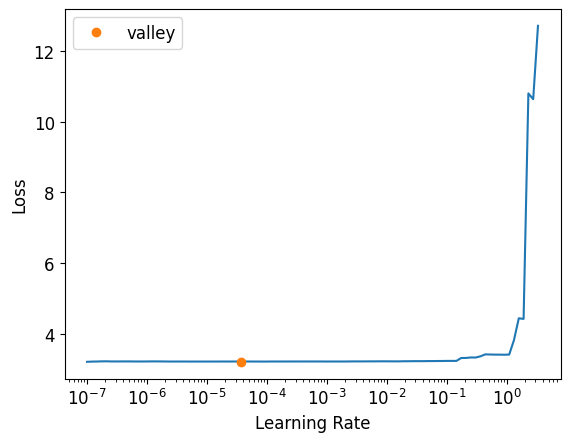

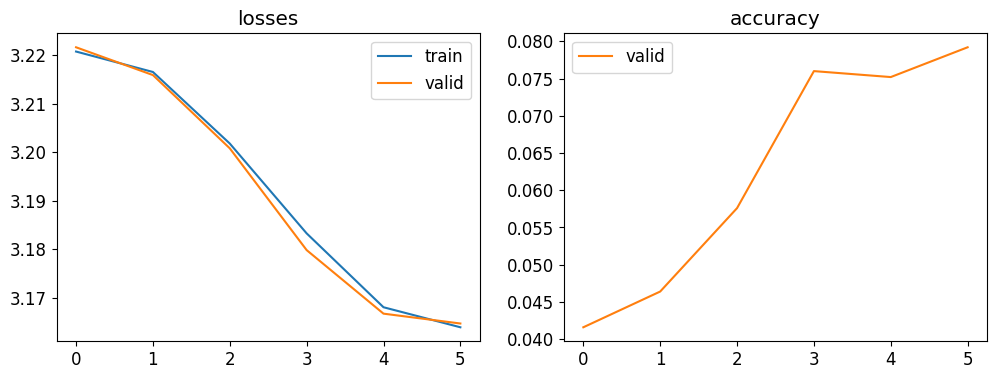


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  4.16 %

	ÉPOCA 1 :  4.64 %

	ÉPOCA 2 :  5.76 %

	ÉPOCA 3 :  7.6 %

	ÉPOCA 4 :  7.52 %

	ÉPOCA 5 :  7.92 %

ACCURACY en el conjunto VALIDATION:  7.92 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

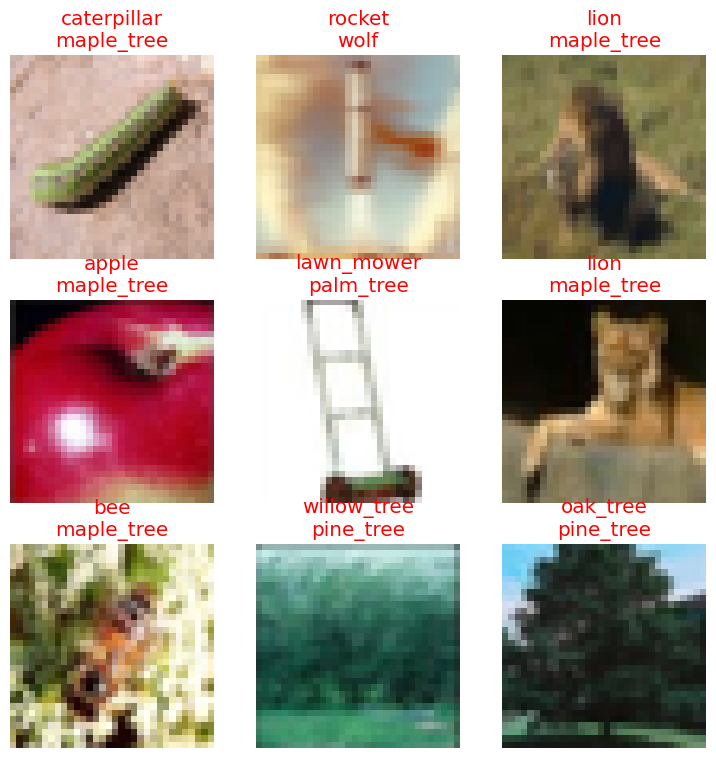

In [ ]:
# Objeto Learner
learn = Learner(dls, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

#learn.recorder.train_metrics = True   # Hace aparecer también train_accuracy en las métricas del modelo

# Encontrar el valor óptimo del learning rate (lr)
lr = learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
learn.fit_one_cycle(n_epoch = 6, lr_max = lr[0])

# Intercambio de posición de las columnas train_accuracy y valid_loss
#learn.recorder.metric_names[2], learn.recorder.metric_names[3] = learn.recorder.metric_names[3], learn.recorder.metric_names[2] # Nombre de train_accuracy <--> Nombre de valid_loss

#for i in range(len(learn.recorder.values)):
  #epoch_metrics_val = learn.recorder.values[i]                                                # Valores de las métricas en la época correspondiente
  #epoch_metrics_val[1], epoch_metrics_val[2] = epoch_metrics_val[2], epoch_metrics_val[1]     # Valores de train_accuracy <--> Valores de valid_loss

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(learn.recorder.values)):
  epoch_metrics_val = learn.recorder.values[i]           # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                  # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
learn.show_results()

# Mostrar todos los detalles del objeto Learner
learn.summary()

### **1.3.3. Observaciones**

El código comentado se usa para mostrar el *train accuracy* en cada época del entrenamiento del modelo en FastAI, lo cual no es necesario para los requerimientos actuales. Inicialmente, al habilitar `learn.recorder.train_metrics = True`, se incluyó el *train accuracy* en el registro de métricas, lo que causó problemas en la visualización de la gráfica de pérdidas. Este cambio alteraba el orden de las columnas, haciendo que la función `learn.recorder.plot_metrics()` interpretara incorrectamente las métricas.

Se intentó reordenar las columnas para corregir el gráfico, pero se observó que los valores finales de *train accuracy* en el entrenamiento diferían de los calculados tras el entrenamiento completo. La causa posible de esta discrepancia es que el *train accuracy* calculado por época se basa en el promedio de cada *batch*, mientras que el cálculo tras el entrenamiento usa el conjunto completo de entrenamiento sin promediar. Por simplicidad, se decidió desactivar el cálculo del *train accuracy* por época y solo mostrar el valor final calculado al generar predicciones, que coincide con el de la matriz de confusión.

### **1.3.4. Predicciones y Matriz de Confusión**

Después de entrenar el modelo, podemos:

Hacer predicciones para un solo ejemplo con learn.predict(example).
Realizar predicciones para un conjunto de datos (como el conjunto de prueba) configurando el dataloader de prueba y usando learn.get_preds(). FastAI normaliza automáticamente los datos de prueba igual que en el entrenamiento.
Para interpretar los resultados, FastAI incluye la clase ClassificationInterpretation, que ofrece métodos como:

from_learner(): Crea una instancia de interpretación.
confusion_matrix(): Calcula la matriz de confusión.
plot_confusion_matrix(): Visualiza la matriz de confusión.
plot_top_losses(): Muestra las clases con mayor confusión.
La matriz de confusión compara predicciones y etiquetas reales, facilitando la evaluación del rendimiento del modelo.

Para más información:

[24] https://docs.fast.ai/interpret.html#classificationinterpretation

[25] https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n

In [ ]:
# Generación de predicciones del modelo entrenado en el conjunto de entrenamiento
preds, targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)

# Accuracy en el conjunto de entrenamiento
acc_train = accuracy(preds, targs)
print('\nACCURACY en el conjunto TRAINING: ', round(float(acc_train) * 100, 4), '%')


ACCURACY en el conjunto TRAINING:  7.8933 %



Número de ejemplos de training: 11250



ACCURACY en el conjunto TRAINING:  7.8933 %


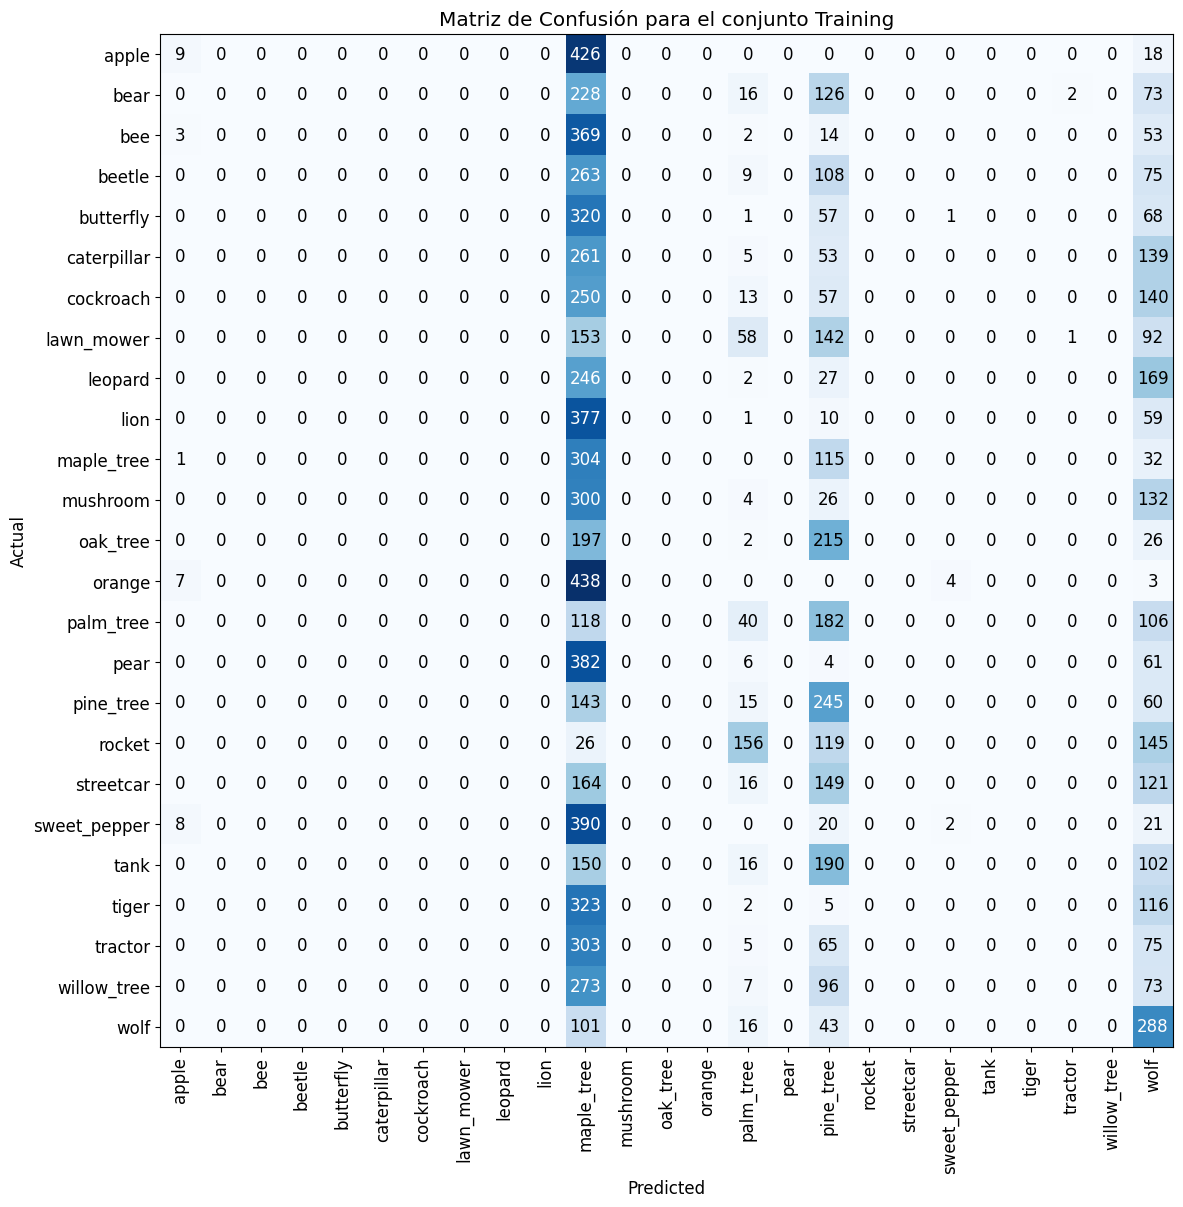

In [ ]:
# Matriz de confusión del conjunto de entrenamiento
interp_train = ClassificationInterpretation.from_learner(learn, 0, dls.train)
cm_train = interp_train.confusion_matrix()

print('\nNúmero de ejemplos de training:', np.sum(cm_train))
interp_train.plot_confusion_matrix(figsize = (12, 12), title = 'Matriz de Confusión para el conjunto Training')
print('\nACCURACY en el conjunto TRAINING: ', round(np.sum(np.diagonal(cm_train)) / np.sum(cm_train) * 100, 4), '%')

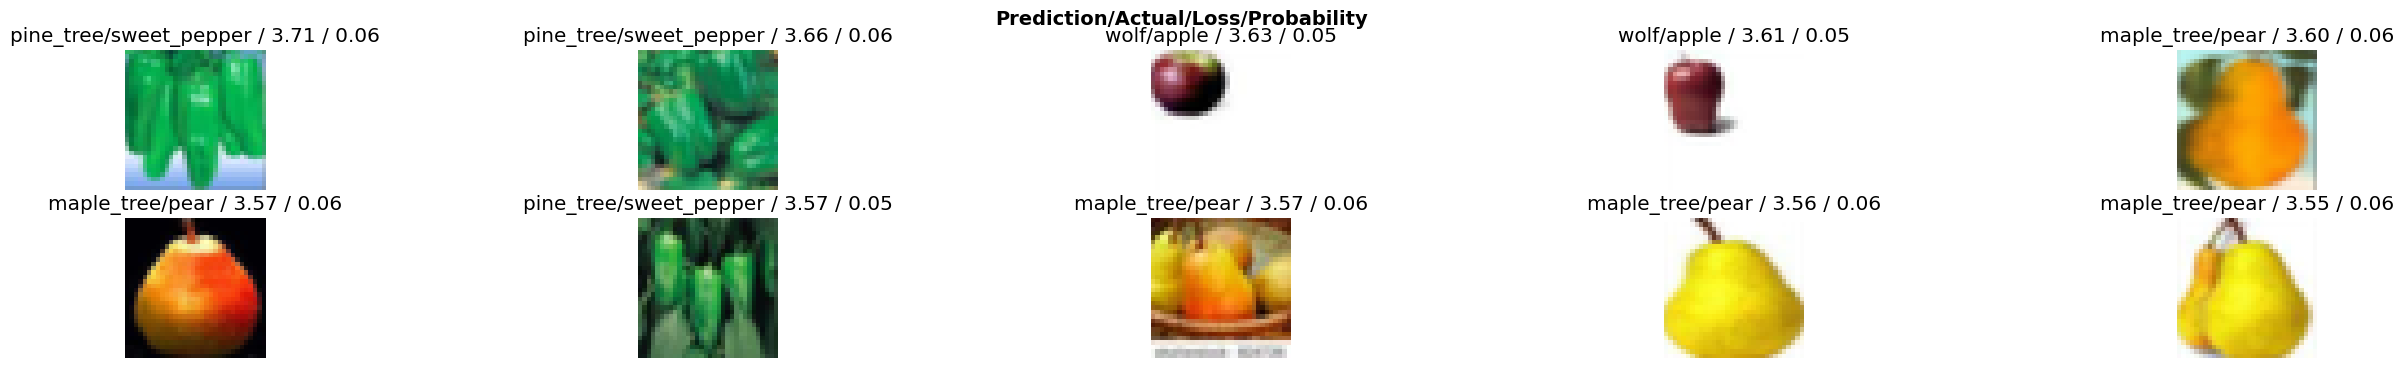

In [ ]:
# Mostrar las 10 clases del conjunto de entrenamiento con el mayor nivel de confusión
interp_train.plot_top_losses(10, nrows = 2, figsize = (32,4))

In [ ]:
# Definición del DataLoad para el conjunto de datos de prueba (test)
test_CIFAR100dl = learn.dls.test_dl(files_test, with_labels = True)

# Generación de predicciones del modelo entrenado en el conjunto de test
preds, targs, _ = learn.get_preds(dl = test_CIFAR100dl, with_decoded = True)

# Accuracy en el conjunto de test
acc_test = accuracy(preds, targs)
print('\nACCURACY en el conjunto TEST: ', round(float(acc_test) * 100, 4), '%')


ACCURACY en el conjunto TEST:  7.84 %



Número de ejemplos de test: 2500



ACCURACY en el conjunto TEST:  7.84 %


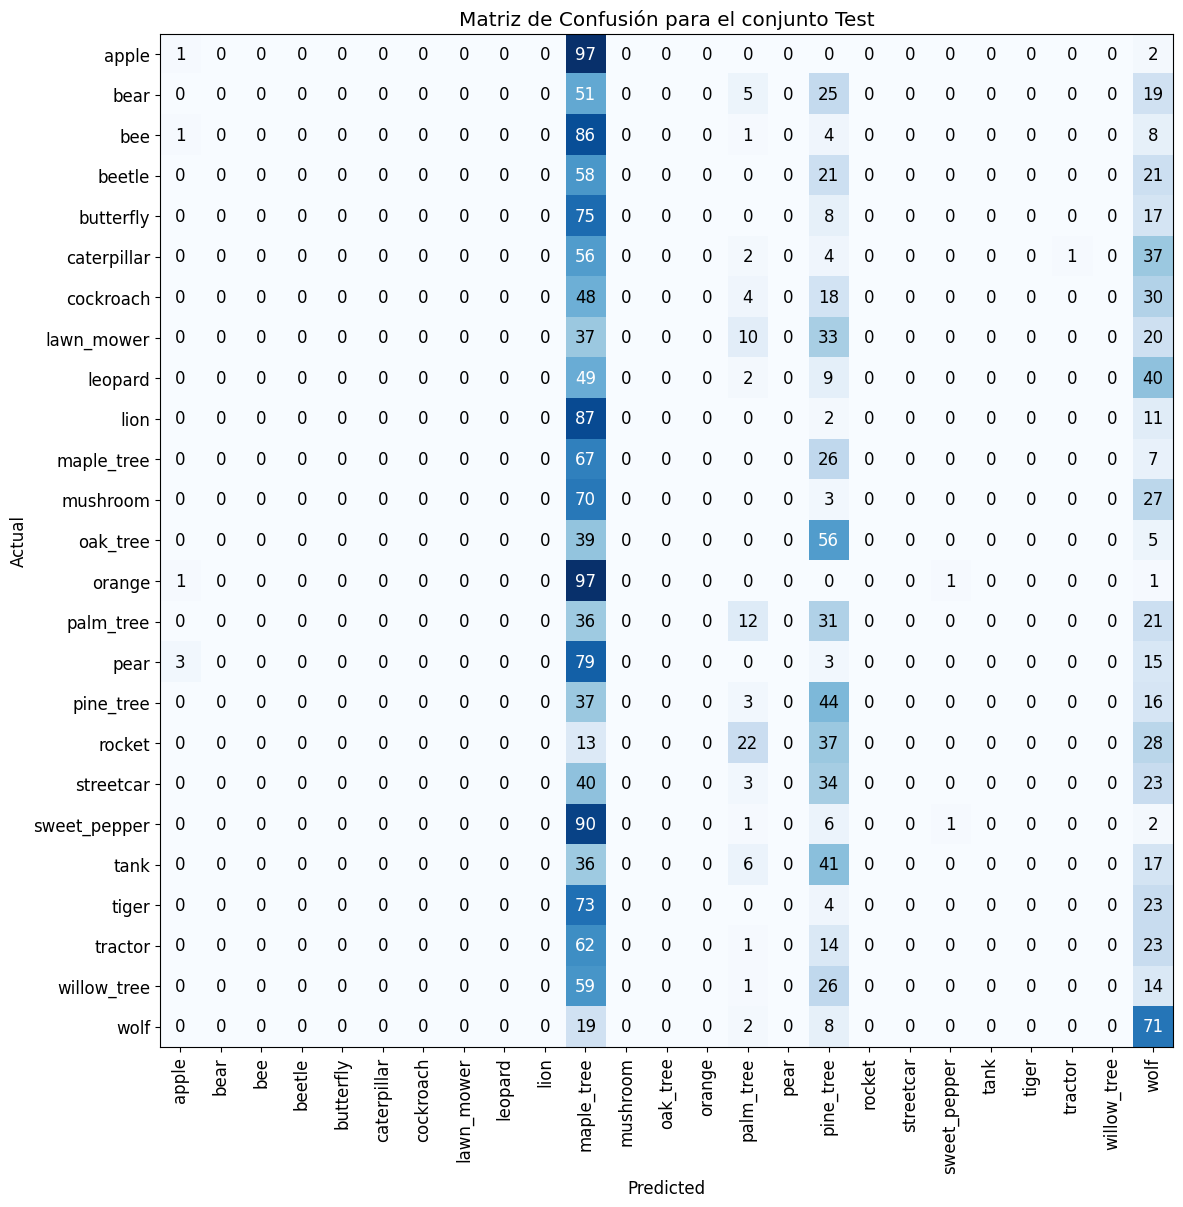

In [ ]:
# Matriz de confusión del conjunto de test
interp_test = ClassificationInterpretation.from_learner(learn, 1, test_CIFAR100dl)
cm_test = interp_test.confusion_matrix()

print('\nNúmero de ejemplos de test:', np.sum(cm_test))
interp_test.plot_confusion_matrix(figsize = (12, 12), title = 'Matriz de Confusión para el conjunto Test')
print('\nACCURACY en el conjunto TEST: ', round(np.sum(np.diagonal(cm_test)) / np.sum(cm_test) * 100, 4), '%')

Podemos ver que, si bien la línea vertical destaca por encima de las demás zonas, hay algunos elementos que no pertenecen a la diagonal que también destacan y que nuestro modelo confunde. Comentemos algunos:

- Fila Lobo (wolf), Columna maple_tree: 19 veces se ha confundido un lobo con un árbol de sauce
-  Fila Cohete (rocket), Columna palm_tree: 22 veces se ha confundido un cohete con una palmera.

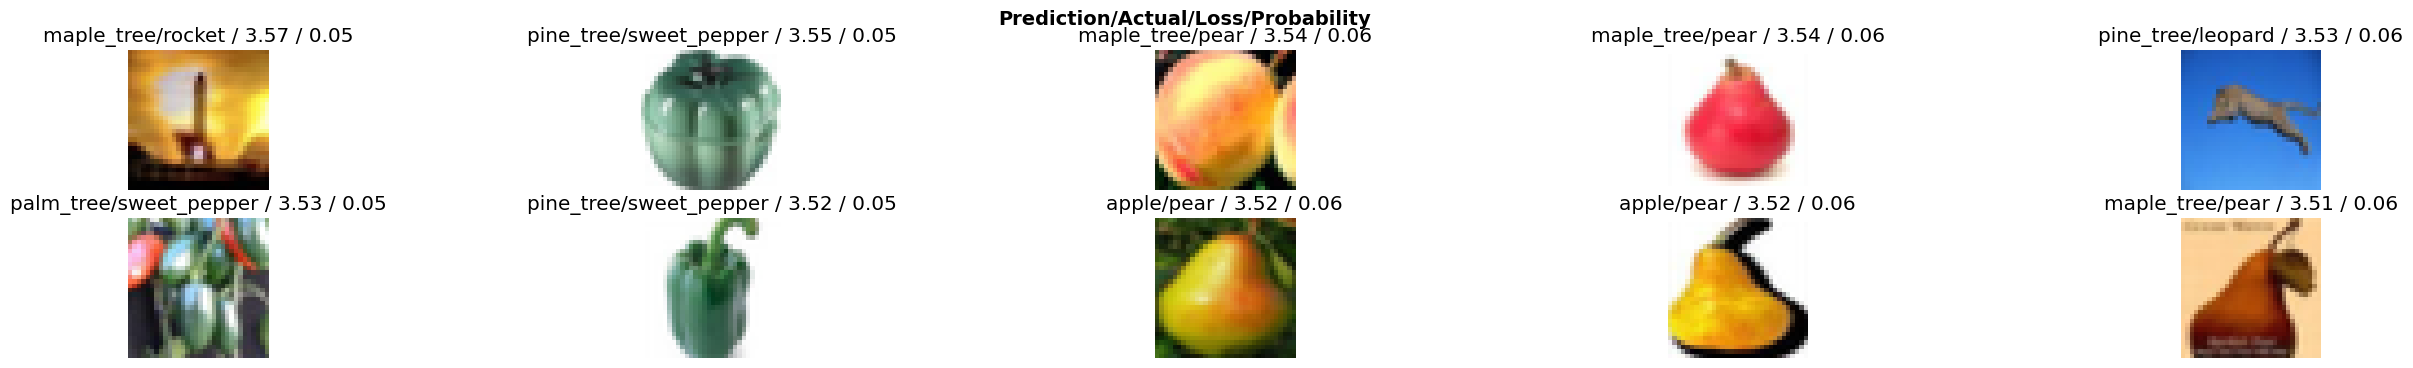

In [ ]:
# Mostrar las 10 clases del conjunto de test con el mayor nivel de confusión
interp_test.plot_top_losses(10, nrows = 2, figsize = (32,4))

### **1.3.5. Análisis de los Resultados**

- Loss en Training: 3.163957

- Accuracy en Training: 0.079200

- Loss en Validation: 3.164734

- Accuracy en Validation: 0.0792

- Accuracy en Test: 0.0784

La tabla de métricas muestra que la pérdida está disminuyendo tanto en el conjunto de entrenamiento como en el de validación, lo cual sugiere que el modelo está aprendiendo y generalizando bien. Aunque hay algo de sobreajuste, no es muy significativo; la pérdida en validación sigue una tendencia similar a la de entrenamiento hasta la época 3, donde comienza a disminuir a un ritmo más lento. Además, la precisión en el conjunto de validación mejora, lo cual es positivo, aunque aún podría optimizarse. Por ello, en el ejercicio 2 se harán ajustes en la arquitectura para mejorar el rendimiento y reducir el sobreajuste.

<font color='blue'>What is the total number of parameters of the created model? Break down the account made to reach that figure.




Para calcular el número total de parámetros de nuestro modelo, necesitamos sumar el número de parámetros en cada capa.

La fórmula general para calcular el número de parámetros en una capa convolucional es:

$$ \text{Número de parámetros} = (\text{Tamaño del kernel} ⋅ \text{Número de canales de entrada} + 1\ \text{(en caso de haber bias)}) ⋅ \text{Número de canales de salida}$$

También, aunque no se pida, justificaremos el volumen de salida de cada capa convolucional, el cual se calcula mediante la fórmula:

$$ \text{Tamaño de salida} = \left( \frac{N + 2 \cdot P - F}{\text{stride}} \right) + 1 $$

donde:

- $\text{Tamaño de salida}$: Tamaño de la salida de la capa convolucional. Representa las dimensiones (altura y ancho) del volumen resultante después de aplicar la operación de convolución.

- $N$: Tamaño de la entrada (input volume). En el contexto de la capa convolucional, esto se refiere al tamaño de la imagen de entrada.

- $P$: Es el tamaño del relleno (padding). Como ya se explicó anteriormente, el relleno se agrega a la entrada antes de aplicar la convolución y este ayuda a mantener el tamaño de la salida. Puede ser útil para evitar la pérdida de información en los bordes de la imagen.

- $F$: Altura/Anchura (son iguales) del filtro/kernel.

- $stride$: Es el tamaño del paso (stride). Como ya se explicó anteriormente, este indica la cantidad de píxeles que el filtro se desplaza en cada paso durante la convolución.

También tenemos la fórmula general para calcular el número de parámetros en una capa fully-connected:

$$ \text{Número de parámetros} = (\text{in_features} + 1\ \text{(en caso de haber bias)}) ⋅ \text{out_features}$$

donde:

- $\text{in_features}$: Número de neuronas en la entrada de la capa.
- $\text{out_features}$: Número de neuronas en la salida de la capa.

Vamos a desglosar la cuenta para cada capa del modelo:

1. Primera capa convolucional:
  - Volumen de entrada: 32 x 32 x 3 ($N = 32$).
  - Filtros/Kernels usados: 5 de 9 x 9 con stride 1 y padding 0 ($F = 9, P = 0, stride = 1$).
  - Volumen de salida: $$\left( \frac{N + 2 \cdot P - F}{\text{stride}} \right) + 1 = \frac{32 + 0 - 9}{1} + 1 = 24$$
  - Salida: 24 x 24 x 5
  - Número de parámetros: Cada filtro tiene (9 x 9 x 3) + 1 = 244 --> La capa tiene 244 x 5 = 120 parámetros (coincide con el número indicado en el resumen del modelo dado por la función `learn.summary()`).

2. Primera capa de activación ReLU: No se calculan parámetros.

3. Capa de Max Pooling: No se calculan parámetros (pero, al aplicarse un filtro 2 x 2 con stride = 2, reduce a la mitad las dimensiones del volumen de salida de la anterior capa convolucional. Es decir, si el volumen de salida era de 24 x 24 x 5, ahora pasa a ser de 12 x 12 x 5).

4. Segunda capa convolucional:
  - Volumen de entrada: 12 x 12 x 5.
  - Filtros/Kernels usados: 10 de 7 x 7 con stride 1 y padding 0 ($F = 7, P = 0, stride = 1$).
  - Volumen de salida: (12 + 0 - 7)/1 + 1 = 6
  - Salida: 6 x 6 x 10
  - Número de parámetros: Cada filtro tiene (7 x 7 x 5) + 1 = 246 parámetros --> La capa tiene 246 * 10 = 2460 parámetros (coincide con el número indicado en el resumen del modelo dado por la función `learn.summary()`).

5. Segunda capa de activación ReLU: No se calculan parámetros.

6. Capa fully-connected (FC):
  - Volumen de entrada: 6 x 6 x 10 = 360
  - Número de neuronas en la salida: 50
  - Número de parámetros: (neurona de entrada + 1) x neurona de salida = (360 + 1) x 50 = 18,050 parámetros.

7. Capa activación ReLU:
  - Volumen entrada/salida: 50 (las dimensiones no cambian).
  - No se calculan parámetros.

8. Capa de activación Softmax (no se incluye explícitamente en el modelo, pero se encuentra internamente. Véase la respuesta a la segunda pregunta de este ejercicio): No se calculan parámetros.

Ahora, sumamos el número de parámetros de todas las capas:

$$ 1220+ 0 + 0 + 2460 + 0 + 18,050+ 0+ 1275 = 21,985$$

En conclusión:

$$ \text{Número total de parámetros del modelo} = 21\ 985, $$

lo cual coincide con el número indicado en el resumen del modelo dado por la función `learn.summary()`, tal y como se esperaba.

<font color='blue'>¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?

En FastAI, no es necesario añadir manualmente una capa `nn.Softmax()` al final del modelo cuando se trabaja con problemas de clasificación multiclase, como en este caso. Esto se debe a que FastAI gestiona automáticamente la activación softmax dentro de la función de pérdida y las métricas correspondientes.

En particular, al utilizar la función de pérdida `CrossEntropyLossFlat()` en el objeto `Learner`, como se ha hecho en el código, esta ya incluye la operación softmax. Esto puede confirmarse al revisar la implementación de `CrossEntropyLossFlat()` en FastAI, disponible en el siguiente enlace:

[26] https://github.com/fastai/fastai/blob/master/fastai/losses.py#L62

Por lo tanto, no es necesario implementar una capa softmax explícita después de la última capa lineal del modelo, ya que FastAI incorpora esta funcionalidad directamente a través de la función de pérdida y las métricas asociadas.

# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


Exploraremos cada una de estas técnicas de manera individual en FastAI para familiarizarnos con su implementación. Nos centraremos principalmente en la métrica de **accuracy** en el conjunto de validación, ya que es la clave para evaluar si el modelo está generalizando correctamente, que es nuestro objetivo principal.

Sin embargo, en el modelo final, donde combinaremos varias técnicas de forma justificada, mostraremos todas las métricas relevantes, tal como hicimos en el ejercicio 1.

## **2.1. Mejora 1: Data Normalization**

La normalización de datos es una técnica esencial en el aprendizaje profundo que busca mejorar tanto la convergencia como la estabilidad durante el entrenamiento de los modelos. Sus principales beneficios incluyen:

- **Convergencia más rápida**: Facilita que los modelos alcancen su óptimo más rápidamente durante el entrenamiento.  
- **Estabilidad en el entrenamiento**: Reduce fluctuaciones y mejora la eficiencia del aprendizaje, especialmente en redes neuronales profundas.  
- **Prevención de problemas de gradientes**: Ayuda a evitar gradientes explosivos o desvanecientes, problemas comunes en redes con muchas capas.  

En el caso de imágenes, la normalización consiste en ajustar la escala de los píxeles. Generalmente, se realiza restando la media y dividiendo entre la desviación estándar de la imagen, lo que centra los datos alrededor de cero y ajusta su varianza.

Es fundamental aplicar la misma normalización tanto al conjunto de entrenamiento como al de prueba para mantener la coherencia. Esto implica calcular los parámetros de normalización (media y desviación estándar) usando únicamente el conjunto de entrenamiento y aplicarlos posteriormente a ambos conjuntos.

En FastAI, existen varias formas de aplicar esta técnica dentro de un `DataBlock` mediante la configuración del parámetro `batch_tfms`:

- **`batch_tfms = Normalize.from_stats(*cifar_stats)`**: Utiliza la media y desviación estándar precalculadas para el conjunto CIFAR. Como trabajamos con CIFAR100, emplearemos este método.  
- **`batch_tfms = Normalize()`**: Calcula automáticamente la media y la desviación estándar del conjunto de entrenamiento, útil cuando no se dispone de esta información previamente.  
- **`batch_tfms = Normalize.from_stats(mean, std)`**: Permite introducir manualmente la media y desviación estándar, calculadas previamente, para normalizar los datos.

Para más detalles, puedes consultar la documentación oficial de FastAI:  
[27] https://docs.fast.ai/data.transforms.html#normalize

In [ ]:
#Definición del Datablock
DataNorm_CIFAR100db = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 42),
    get_y = parent_label,
    batch_tfms = Normalize.from_stats(*cifar_stats) #Data Normalization
)

#Definición del DataLoad para el conjunto de datos de train y validation
dls_norm = DataNorm_CIFAR100db.dataloaders(path/'train', bs = 32)

LEARNING RATE: 0.0010000000474974513 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

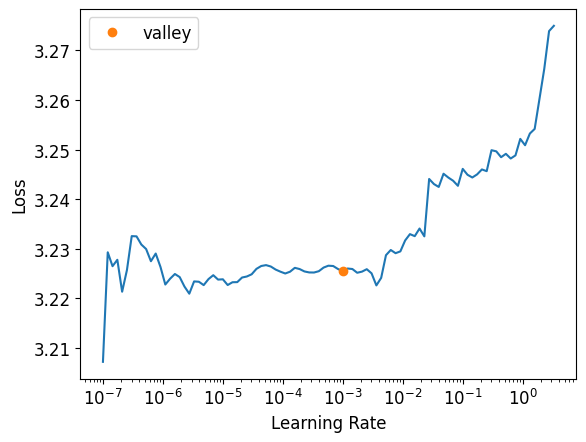

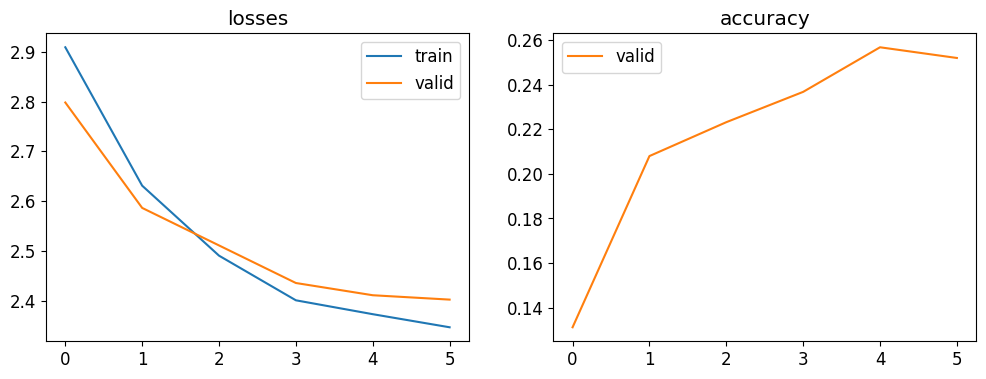


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  13.12 %

	ÉPOCA 1 :  20.8 %

	ÉPOCA 2 :  22.32 %

	ÉPOCA 3 :  23.68 %

	ÉPOCA 4 :  25.68 %

	ÉPOCA 5 :  25.2 %

ACCURACY en el conjunto VALIDATION:  25.2 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

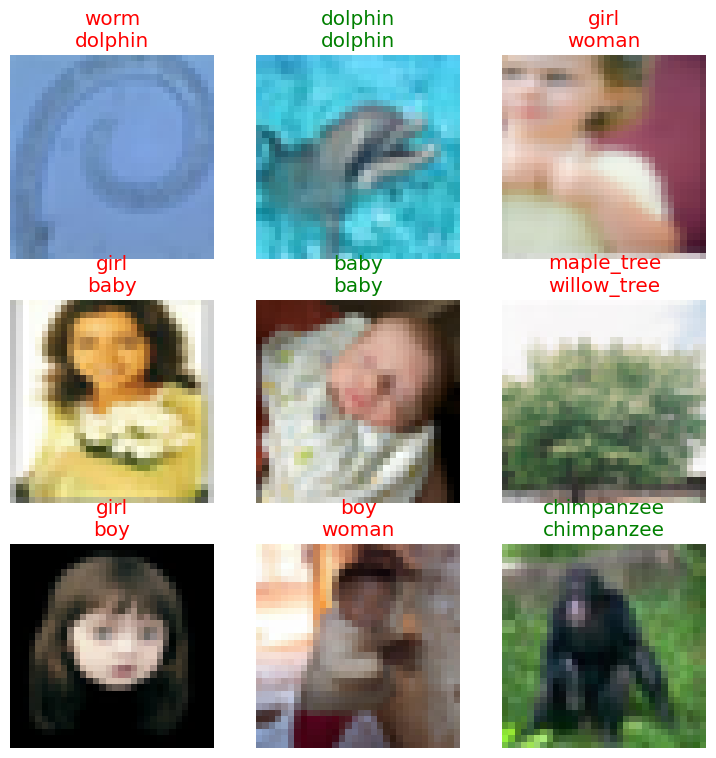

In [ ]:
#Objeto Learner
DataNorm_learn = Learner(dls_norm, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = DataNorm_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
DataNorm_learn.fit_one_cycle(n_epoch = 6, lr_max = lr[0])

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
DataNorm_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = DataNorm_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(DataNorm_learn.recorder.values)):
  epoch_metrics_val = DataNorm_learn.recorder.values[i]  # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                  # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
DataNorm_learn.show_results()

# Mostrar todos los detalles del objeto Learner
DataNorm_learn.summary()

### **2.1.1. Análisis de los Resultados**

- Loss en Training: 2.346314

- Loss en Validation: 2.401912

- Accuracy en Validation: 0.252000

Al analizar la tabla que muestra las métricas por época, observamos que la pérdida en el conjunto de entrenamiento disminuye progresivamente, lo cual es una señal positiva. Asimismo, la pérdida en el conjunto de validación también se reduce, lo que indica que el modelo está generalizando correctamente a datos no vistos.

Además, el accuracy en el conjunto de validación mejora de forma gradual con el tiempo, lo cual es alentador. Es importante destacar que, al aplicar la normalización de datos, se logra una mejora en el accuracy del conjunto de validación, pasando de un 7% a un 25.20%.

Comparando estos resultados con los obtenidos en el ejercicio 1, podemos notar lo siguiente:

La normalización de datos parece favorecer un mejor desempeño del modelo en términos de accuracy.
Contribuye a una mejor generalización, ya que la diferencia entre la pérdida en el conjunto de entrenamiento y la de validación es menor en comparación con el modelo sin normalización (lo que indica una reducción del overfitting, aunque aún está presente).
Ambos modelos muestran una tendencia positiva, con incrementos en el accuracy y disminuciones en las pérdidas a medida que avanzan las épocas.

## **2.2. Mejora 2: Batch Normalization**



**Batch Normalization** es una técnica utilizada para normalizar las activaciones de cada capa en una red neuronal. Esto se logra calculando la media y la desviación estándar de las activaciones dentro de un mini-batch y normalizándolas al restar la media y dividir entre la desviación estándar. Sus principales beneficios son:

- **Mitigar el desvanecimiento o explosión del gradiente**: Mantiene las activaciones dentro de un rango estable, reduciendo problemas de gradientes que se desvanecen o explotan.  
- **Acelerar el entrenamiento**: Permite utilizar tasas de aprendizaje más altas, lo que acelera el proceso de optimización.  
- **Mejorar la generalización**: Ayuda al modelo a generalizar mejor cuando se enfrenta a datos nuevos.

Batch Normalization puede aplicarse después de las capas convolucionales, y también después de la función de activación (como ReLU), lo que en algunos casos resulta beneficioso. De igual manera, puede implementarse tras capas fully-connected, siendo especialmente útil en arquitecturas profundas.

No existe una regla fija sobre el lugar óptimo para aplicarla, ya que esto depende de la arquitectura del modelo y de la naturaleza de los datos. Por lo tanto, es recomendable experimentar con diferentes configuraciones y evaluar su impacto en el rendimiento del modelo.

En **FastAI**, esta técnica se implementa añadiendo una capa `nn.BatchNorm2d(num_features)` después de una capa convolucional (o de la función de activación) y/o una capa `BatchNorm1d(num_features)` tras una capa fully-connected.

Para más información, podemos consultar la documentación oficial de PyTorch:  
- [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)  
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

In [ ]:
#Creación del modelo
BatchNorm_BaseNet = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size=(9,9)),
    nn.BatchNorm2d(num_features = 5),                                           #Batch Normalization después de la capa de convolución
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),
    nn.Tanh(),
    nn.BatchNorm2d(num_features = 10),                                          #Batch Normalization después de la capa de convolución y la función de activación Tanh
    nn.Flatten(),
    nn.Linear(in_features = 360, out_features=50),
    nn.BatchNorm1d(num_features = 50),                                          #Batch Normalization después de la capa fully-connected
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25)
)

LEARNING RATE: 0.013182567432522774 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

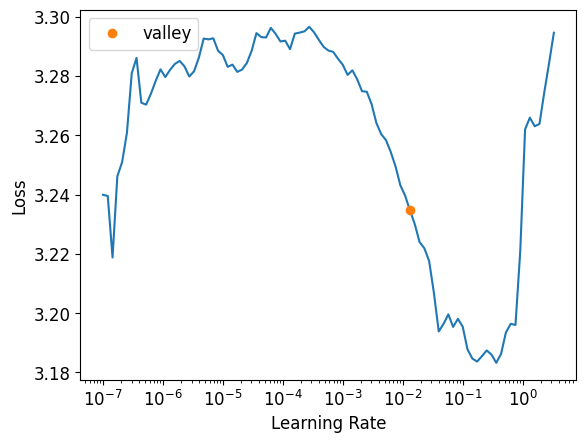

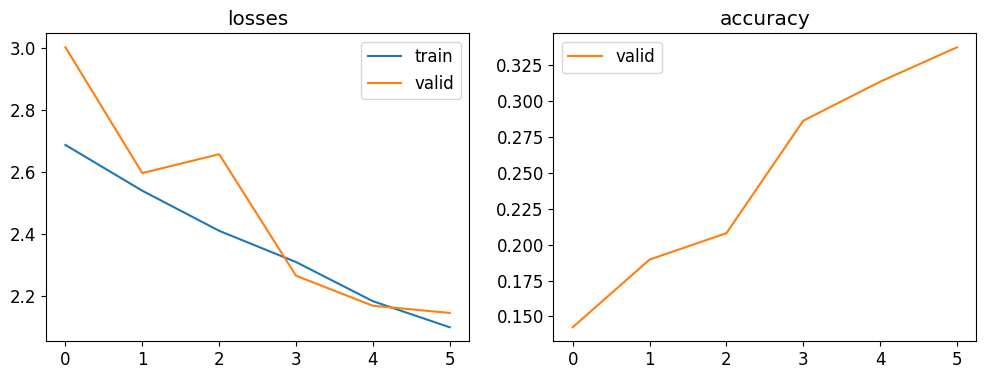


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  14.24 %

	ÉPOCA 1 :  18.96 %

	ÉPOCA 2 :  20.8 %

	ÉPOCA 3 :  28.64 %

	ÉPOCA 4 :  31.36 %

	ÉPOCA 5 :  33.76 %

ACCURACY en el conjunto VALIDATION:  33.76 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
BatchNorm2d                               10         True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
BatchNorm2d                               20         True      
____________________________________________________________________________
                     32 x 360            
Flatten                                       

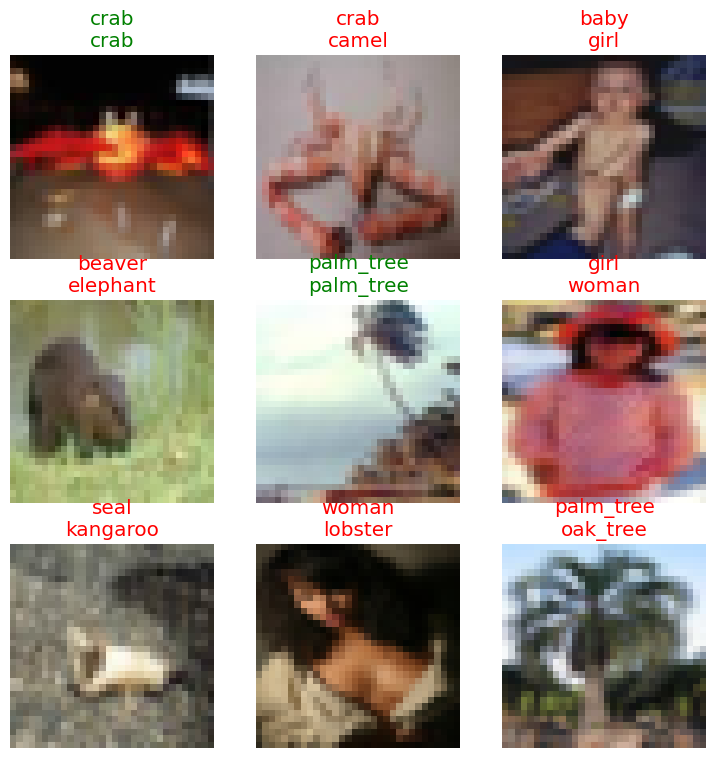

In [ ]:
# Objeto Learner
BatchNorm_learn = Learner(dls, BatchNorm_BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = BatchNorm_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
BatchNorm_learn.fit_one_cycle(n_epoch = 6, lr_max = lr[0])

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
BatchNorm_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = BatchNorm_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(BatchNorm_learn.recorder.values)):
  epoch_metrics_val = BatchNorm_learn.recorder.values[i] # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                  # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
BatchNorm_learn.show_results()

# Mostrar todos los detalles del objeto Learner
BatchNorm_learn.summary()

### **2.2.1. Análisis de los Resultados**

- Loss en Training: 2.098568

- Loss en Validation: 2.144778

- Accuracy en Validation: 0.337600

Al analizar la tabla que detalla las métricas obtenidas por época, se observa que la pérdida en el conjunto de entrenamiento disminuye de forma constante, lo que indica una buena convergencia del modelo. De igual manera, la pérdida en el conjunto de validación también se reduce, lo cual sugiere que el modelo está generalizando correctamente a datos no vistos.

Adicionalmente, el **accuracy** en el conjunto de validación muestra una mejora gradual con el tiempo, lo que resulta prometedor. Es importante resaltar que la aplicación de **Batch Normalization** ha generado una mejora notable en el **accuracy** del conjunto de validación, incrementándolo de un 25% a un 33.76%.

Al comparar estos resultados con los obtenidos en el ejercicio 1, se pueden destacar los siguientes puntos:

- La inclusión de **Batch Normalization** ha incrementado significativamente el rendimiento del modelo.  
- La diferencia entre las pérdidas del conjunto de entrenamiento y validación es menor en comparación con el modelo sin normalización, lo que indica una reducción del sobreajuste y una mejor regularización del modelo.  
- El aumento en la precisión del conjunto de validación confirma que **Batch Normalization** ha mejorado la capacidad del modelo para generalizar a datos nuevos.  

## **2.3. Mejora 3: Depth Increase**

La técnica de **Depth Increase** en deep learning consiste en aumentar la profundidad de una red neuronal convolucional mediante la incorporación de capas adicionales. En este contexto, la profundidad hace referencia al número total de capas que conforman la red. Esta estrategia ofrece varias ventajas clave:

- **Mayor capacidad representativa**: Al agregar más capas convolucionales, la red puede aprender representaciones más complejas y abstractas de los datos. No es necesario incluir una capa de *max pooling* después de cada capa convolucional, ya que esto podría provocar una pérdida excesiva de información espacial. En su lugar, es posible utilizar capas como *UpSampling* o *Transposed Convolution* para mejorar la resolución espacial.

- **Mejora en la jerarquía de características**: A medida que se incrementa la profundidad de la red, cada capa convolucional es capaz de captar características más específicas y de alto nivel, enriqueciendo la jerarquía de representaciones.

- **Mayor expresividad del modelo**: Una red más profunda posee más parámetros, lo que aumenta su capacidad para captar patrones complejos y relaciones en los datos.

Es importante monitorear el número de parámetros a medida que se incrementa la profundidad para evitar problemas como el sobreajuste y la necesidad de recursos computacionales excesivos.

Tomaremos como base arquitecturas de clasificación vistas en la teoría, ya que sabemos que son funcionales. Si observamos la arquitectura de nuestra red *BaseNet*, se pueden identificar similitudes con la conocida arquitectura *LeNet-5*. Cabe destacar que *LeNet-5* fue superada por *AlexNet*, lo que marcó un avance significativo en el campo de deep learning. Por ello, aumentaremos la profundidad de nuestra arquitectura *BaseNet* tomando como referencia *AlexNet* y adaptándola a nuestro problema específico (aunque no garantizamos obtener mejores resultados).

Debido a que *AlexNet* fue diseñada para imágenes de entrada de 227 x 227 x 3 y nuestras imágenes son de 32 x 32 x 3, necesitamos realizar ciertas adaptaciones. Las soluciones posibles son:

- **Interpolar las imágenes de 32 x 32 a 227 x 227**: Esta opción no es ideal, ya que el aumento sería excesivo y no agregaría información útil.

- **Reducir el tamaño del filtro/kernel**, manteniendo la filosofía original de la arquitectura (elegiremos esta alternativa).

In [ ]:
BaseNet_Deep = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=2, padding=1),  # Capa 1: Convolución
    nn.ReLU(inplace=True),                                                              # Capa 2: Función de Activación ReLU
    nn.MaxPool2d(kernel_size=(2, 2)),                                                   # Capa 3: MaxPooling 2x2
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1),           # Capa 4: Convolución
    nn.Tanh(),                                                                          # Capa 5: Función de Activación ReLU
    nn.MaxPool2d(kernel_size=(2, 2)),                                                   # Capa 6: MaxPooling 2x2
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),          # Capa 7: Convolución
    nn.ReLU(inplace=True),                                                              # Capa 8: Función de Activación ReLU
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),          # Capa 9: Convolución
    nn.ReLU(inplace=True),                                                              # Capa 10: Función de Activación ReLU
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),         # Capa 11: Convolución
    nn.ReLU(inplace=True),                                                              # Capa 12: Función de Activación ReLU
    nn.MaxPool2d(kernel_size=(2, 2)),                                                   # Capa 13: MaxPooling 2x2
    nn.AdaptiveAvgPool2d(output_size=(4, 4)),                                           # Capa 14: AdaptiveAvgPool2D (reduce salida a 4x4)
    nn.Flatten(),                                                                       # Capa 15: Tensor tridimensional a 1D
    nn.Linear(in_features=2048, out_features=100),                                      # Capa 16: Fully-Connected
    nn.ReLU(inplace=True),                                                              # Capa 17: Función de Activación ReLU
    nn.Linear(in_features=100, out_features=50),                                        # Capa 18: Fully-Connected
    nn.ReLU(inplace=True),                                                              # Capa 19: Función de Activación ReLU
    nn.Linear(in_features=50, out_features=25)                                          # Capa 20: Fully-Connected (25 clases de salida)
)



Cambios realizados:
Capas convolucionales adicionales:

Se añadieron dos nuevas capas convolucionales:
Una con 20 filtros y un tamaño de kernel de (5, 5).
Otra con 40 filtros y un tamaño de kernel de (3, 3), con padding para mantener las dimensiones.
Esto aumenta la capacidad representativa del modelo para aprender características más complejas.
Activaciones y agrupaciones respetadas:

Se mantuvieron las activaciones originales (Sigmoid y Tanh) en las nuevas capas convolucionales, para preservar la coherencia con el diseño original.
Se añadió una operación de MaxPooling después de la nueva capa de 20 filtros para reducir la dimensionalidad.
Capas densas mejoradas:

La primera capa Fully Connected aumenta de 360 a 640 nodos (ajustado al tamaño del flatten tras las nuevas capas convolucionales).
Se incrementa el número de nodos en la segunda capa Fully Connected de 50 a 100 para manejar la salida enriquecida.
Estructura balanceada:

Las capas adicionales están intercaladas con activaciones y operaciones de MaxPooling para mantener la regularización y evitar problemas de sobreajuste.

LEARNING RATE: 0.0006918309954926372 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

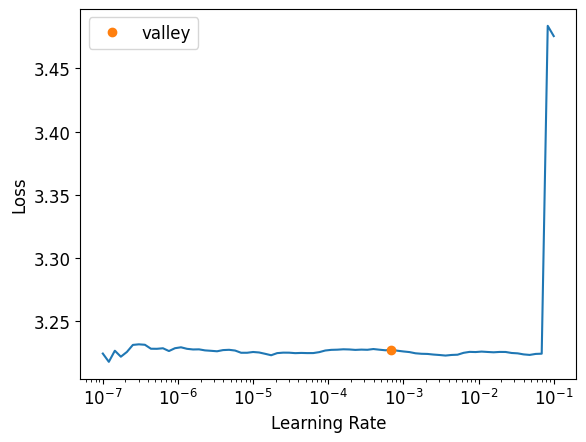

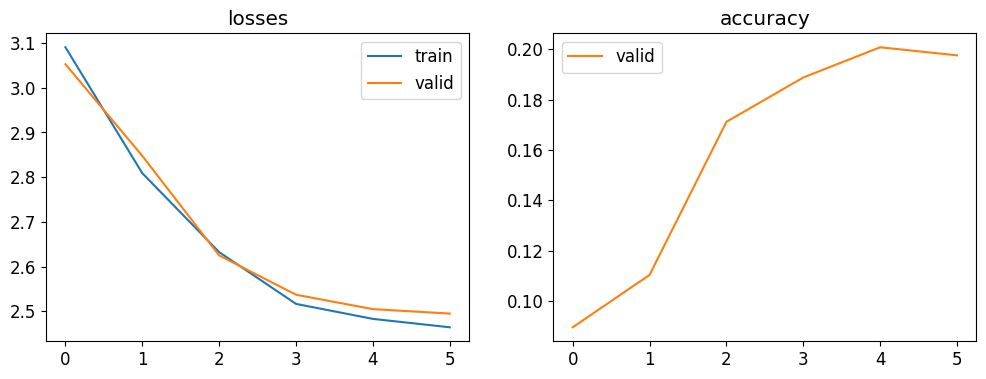


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  8.96 %

	ÉPOCA 1 :  11.04 %

	ÉPOCA 2 :  17.12 %

	ÉPOCA 3 :  18.88 %

	ÉPOCA 4 :  20.08 %

	ÉPOCA 5 :  19.76 %

ACCURACY en el conjunto VALIDATION:  19.76 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8 x 16 x 16    
Conv2d                                    224        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 8 x 8 x 8      
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 16 x 8 x 8     
Conv2d                                    1168       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 32 x 4 

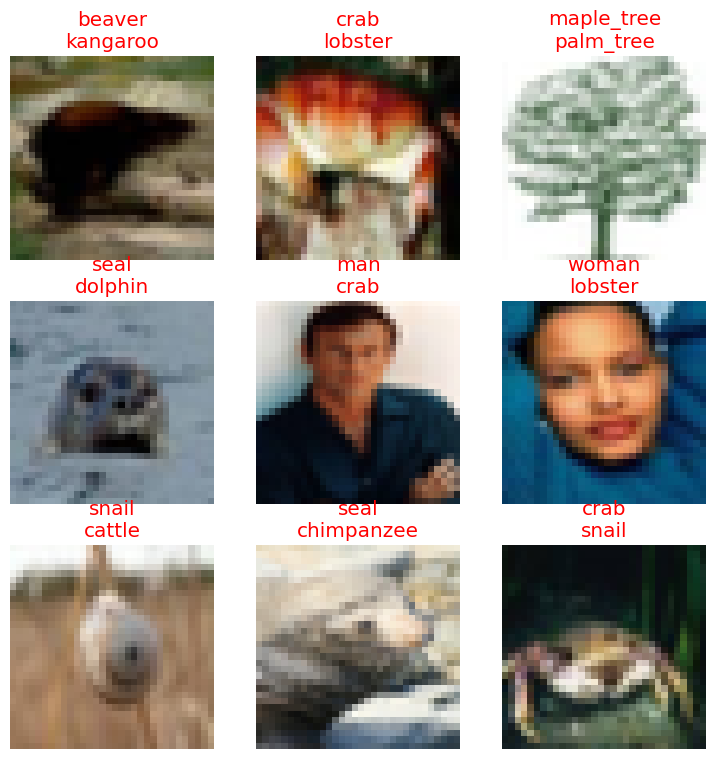

In [ ]:
# Objeto Learner
DepthInc_learn = Learner(dls, BaseNet_Deep, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = DepthInc_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
DepthInc_learn.fit_one_cycle(n_epoch = 6, lr_max = lr[0])

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
DepthInc_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = DepthInc_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(DepthInc_learn.recorder.values)):
  epoch_metrics_val = DepthInc_learn.recorder.values[i]  # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                  # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
DepthInc_learn.show_results()

# Mostrar todos los detalles del objeto Learner
DepthInc_learn.summary()

### **2.3.1. Análisis de los Resultados**

- Loss en Training: 2.464363

- Loss en Validation: 2.495008

- Accuracy en Validation: 0.197600

Al examinar la tabla que muestra los valores de las métricas por cada época, podemos observar que la pérdida en el conjunto de entrenamiento disminuye, lo cual es un indicio positivo de que el modelo está convergiendo adecuadamente. Además, la pérdida en el conjunto de validación también baja, lo que sugiere que el modelo está generalizando bien a datos no vistos.

En la misma tabla, también se observa que la precisión en el conjunto de validación aumenta gradualmente a lo largo del tiempo, lo cual es otra señal positiva. Sin embargo, es importante señalar que el valor de la precisión en el conjunto de validación es bastante bajo en este caso. Esto podría deberse a que la arquitectura con mayor profundidad que estamos utilizando, o los hiperparámetros seleccionados, necesitan ajustes para que esta técnica sea realmente efectiva. Las razones detrás de este comportamiento pueden ser diversas. De todos modos, como mencionamos antes, este no es nuestro modelo final, sino una demostración paso a paso de cada técnica, con el objetivo de combinarlas posteriormente para lograr una mejora significativa en la precisión obtenida en el ejercicio 1.

Comparando estos resultados con los del ejercicio 1, podemos concluir lo siguiente:

El modelo original, sin mejoras, muestra una mayor precisión que el modelo con aumento de profundidad a lo largo de todas las épocas.

La pérdida tanto en entrenamiento como en validación del modelo con aumento de profundidad es consistentemente más alta que la del modelo base en todas las épocas. Esto sugiere que el modelo más profundo podría estar enfrentando dificultades para aprender correctamente o podría estar sobreajustando los datos. Además, la diferencia entre la pérdida de entrenamiento y la de validación es considerablemente menor en comparación con el modelo sin normalización.

## **2.4. Mejora 4: Dropout**

Dropout es una técnica de regularización frecuentemente utilizada en redes neuronales para evitar el sobreajuste (overfitting). Su principio fundamental consiste en desactivar aleatoriamente un grupo de neuronas durante el proceso de entrenamiento, lo que permite que la red se vuelva más robusta y tenga una mejor capacidad para generalizar a datos no vistos.

Durante cada ciclo de entrenamiento, cada neurona tiene una probabilidad específica de ser "apagada" (eliminada temporalmente), un proceso controlado por una tasa de dropout. Esto implica que la neurona no participará en esa iteración ni contribuirá al aprendizaje.

El uso aleatorio del dropout fuerza a las neuronas a no depender demasiado de otras específicas, lo que promueve una mayor independencia entre ellas. Como resultado, el modelo mejora su capacidad de generalización.

En FastAI, para implementar esta técnica, se incorpora la capa `nn.Dropout(p)` después de una capa de convolución o una capa fully-connected.

Para obtener más detalles, se puede consultar la documentación oficial de PyTorch:

[30] https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [ ]:
Dropout_BaseNet = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size=(9,9)),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),
    nn.Tanh(),
    nn.Flatten(),
    nn.Dropout(p = 0.3),                                                        #Dropout con una tasa de 0.3
    nn.Linear(in_features = 360, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25)
)

LEARNING RATE: 0.001737800776027143 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

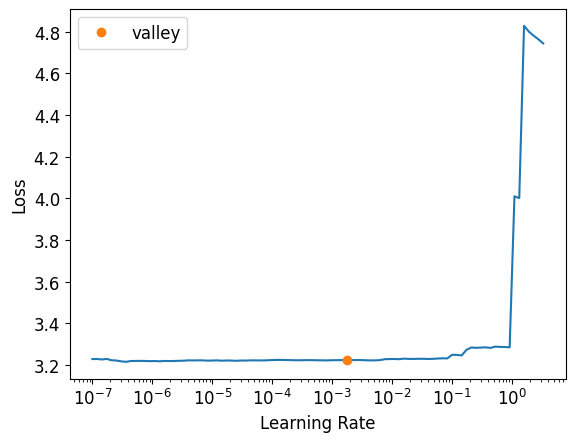

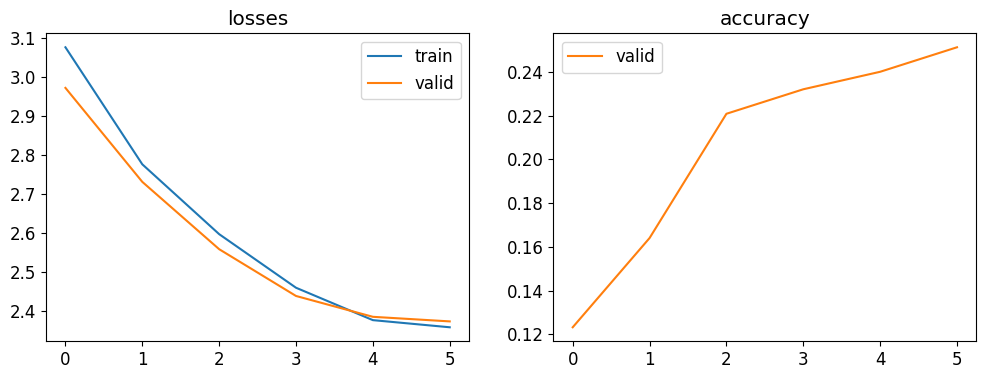


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  12.32 %

	ÉPOCA 1 :  16.4 %

	ÉPOCA 2 :  22.08 %

	ÉPOCA 3 :  23.2 %

	ÉPOCA 4 :  24.0 %

	ÉPOCA 5 :  25.12 %

ACCURACY en el conjunto VALIDATION:  25.12 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
Dropout                                                        
______________________________________________

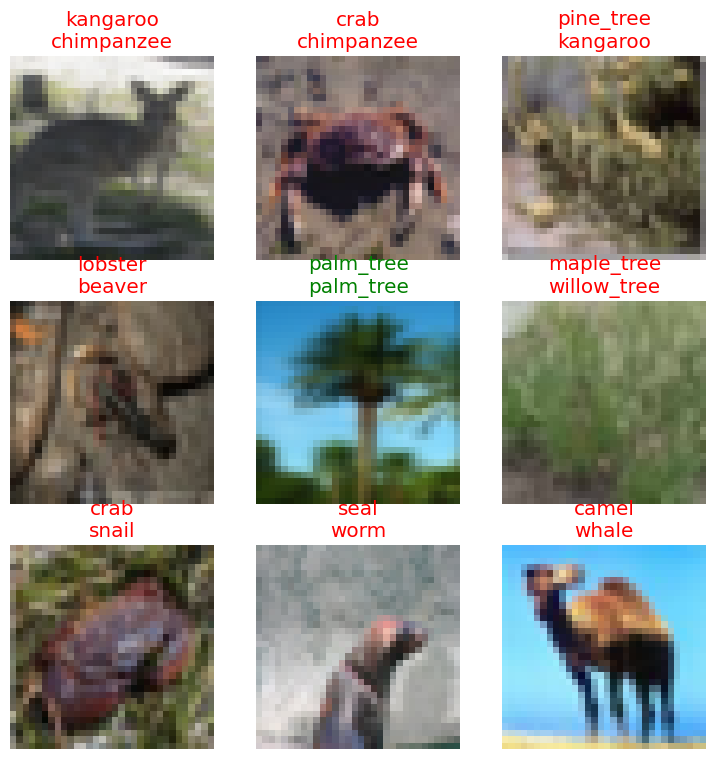

In [ ]:
# Objeto Learner
Dropout_learn = Learner(dls, Dropout_BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = Dropout_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
Dropout_learn.fit_one_cycle(n_epoch = 6, lr_max = lr[0])

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
Dropout_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = Dropout_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(Dropout_learn.recorder.values)):
  epoch_metrics_val = Dropout_learn.recorder.values[i]   # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                  # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
Dropout_learn.show_results()

# Mostrar todos los detalles del objeto Learner
Dropout_learn.summary()

### **2.4.1. Análisis de los Resultados**

- Loss en Training: 2.358319

- Loss en Validation: 2.373379

- Accuracy en Validation: 0.251200

Al revisar la tabla que muestra los valores de las métricas por época, podemos observar que la pérdida en el conjunto de entrenamiento tiende a disminuir, lo cual es un buen indicio de convergencia. Además, la pérdida en el conjunto de validación también disminuye, lo que sugiere que el modelo está logrando una buena capacidad de generalización a datos no vistos.

También es evidente en la tabla que la precisión en el conjunto de validación mejora gradualmente con el tiempo, lo cual es otra señal positiva.

Al comparar estos resultados con los del ejercicio 1, se concluye lo siguiente:

- La pérdida en el conjunto de entrenamiento del modelo con Dropout es generalmente mayor que la del modelo sin Dropout, lo que indica que el modelo con Dropout está aprendiendo menos detalles específicos del conjunto de entrenamiento. Este comportamiento sugiere una reducción del sobreajuste.

- En el conjunto de validación, la pérdida del modelo con Dropout es menor en algunas épocas en comparación con el modelo sin Dropout. Esto sugiere que el modelo con Dropout generaliza mejor a datos no vistos.

- Aunque Dropout contribuye a reducir el sobreajuste, puede causar una ligera disminución en la precisión o, al menos, mantenerla prácticamente igual, como sucede en este caso. Esto se debe a que, al apagar aleatoriamente algunas neuronas durante el entrenamiento, la red puede tener dificultades para ajustar completamente los datos de entrenamiento.

## **2.5. Mejora 5: Early Stopping**

Early Stopping es una técnica utilizada en el entrenamiento de modelos de deep learning para evitar el sobreajuste y mejorar la eficiencia del entrenamiento. La idea básica detrás de esta técnica es detener el entrenamiento del modelo una vez que se cumplan ciertos criterios, evitando así que el modelo continúe aprendiendo más allá del punto óptimo. La elección del número de épocas es crucial: demasiadas épocas pueden llevar al sobreajuste, mientras que muy pocas pueden resultar en un modelo subentrenado. Early Stopping proporciona una forma adaptativa de tomar esta decisión durante el entrenamiento.

Durante el proceso de entrenamiento, se monitorean métricas clave como la pérdida en el conjunto de entrenamiento y la precisión en el conjunto de validación. Estas métricas ofrecen información sobre el rendimiento del modelo en datos de entrenamiento y en datos no vistos.

Los criterios de detención suelen basarse en el comportamiento de estas métricas monitoreadas. Uno de los criterios más comunes es observar si la pérdida en el conjunto de validación deja de disminuir o comienza a aumentar. Otro criterio puede ser si la precisión en el conjunto de validación deja de mejorar.

Para aplicar Early Stopping en FastAI, se puede utilizar la función `fit_one_cycle()` con el parámetro `cbs = EarlyStoppingCallback()`. En la función `EarlyStoppingCallback()`, se pueden especificar parámetros como:

- `monitor`: Indica la métrica que se va a monitorear para determinar si el modelo está mejorando o no. Si no se especifica, se asume `monitor = 'valid_loss'` por defecto.
- `patience`: Número entero que define cuántas épocas consecutivas se permitirá que la métrica monitoreada no mejore antes de detener el entrenamiento.

Para más detalles sobre cómo aplicar Early Stopping en FastAI, se puede consultar la documentación oficial:

[31] https://docs.fast.ai/callback.tracker.html#earlystoppingcallback.

LEARNING RATE: 0.0002754228771664202 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

No improvement since epoch 25: early stopping


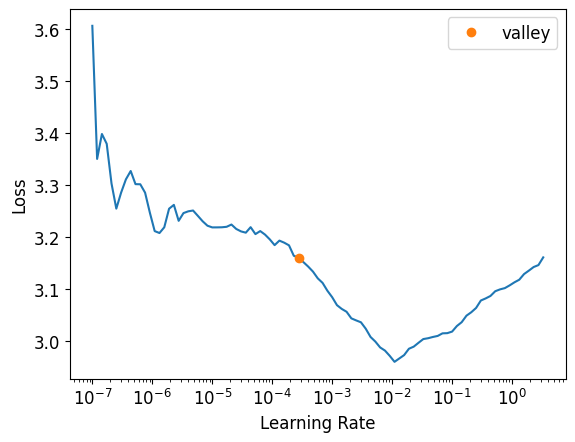

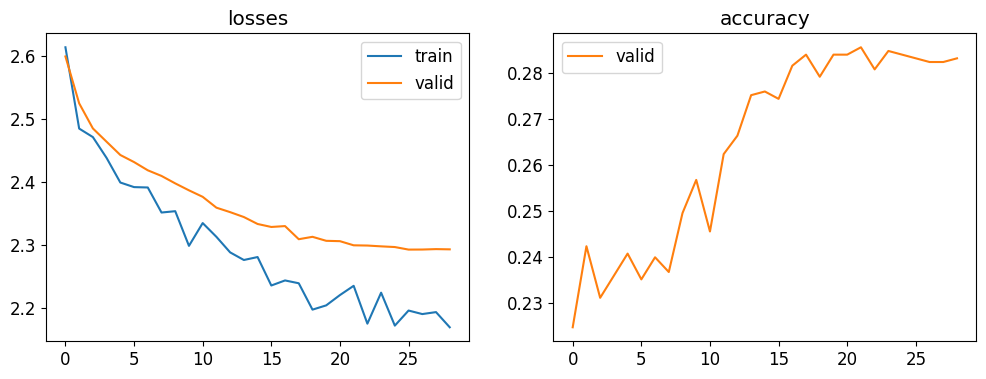


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  22.48 %

	ÉPOCA 1 :  24.24 %

	ÉPOCA 2 :  23.12 %

	ÉPOCA 3 :  23.6 %

	ÉPOCA 4 :  24.08 %

	ÉPOCA 5 :  23.52 %

	ÉPOCA 6 :  24.0 %

	ÉPOCA 7 :  23.68 %

	ÉPOCA 8 :  24.96 %

	ÉPOCA 9 :  25.68 %

	ÉPOCA 10 :  24.56 %

	ÉPOCA 11 :  26.24 %

	ÉPOCA 12 :  26.64 %

	ÉPOCA 13 :  27.52 %

	ÉPOCA 14 :  27.6 %

	ÉPOCA 15 :  27.44 %

	ÉPOCA 16 :  28.16 %

	ÉPOCA 17 :  28.4 %

	ÉPOCA 18 :  27.92 %

	ÉPOCA 19 :  28.4 %

	ÉPOCA 20 :  28.4 %

	ÉPOCA 21 :  28.56 %

	ÉPOCA 22 :  28.08 %

	ÉPOCA 23 :  28.48 %

	ÉPOCA 24 :  28.4 %

	ÉPOCA 25 :  28.32 %

	ÉPOCA 26 :  28.24 %

	ÉPOCA 27 :  28.24 %

	ÉPOCA 28 :  28.32 %

ACCURACY en el conjunto VALIDATION:  28.32 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

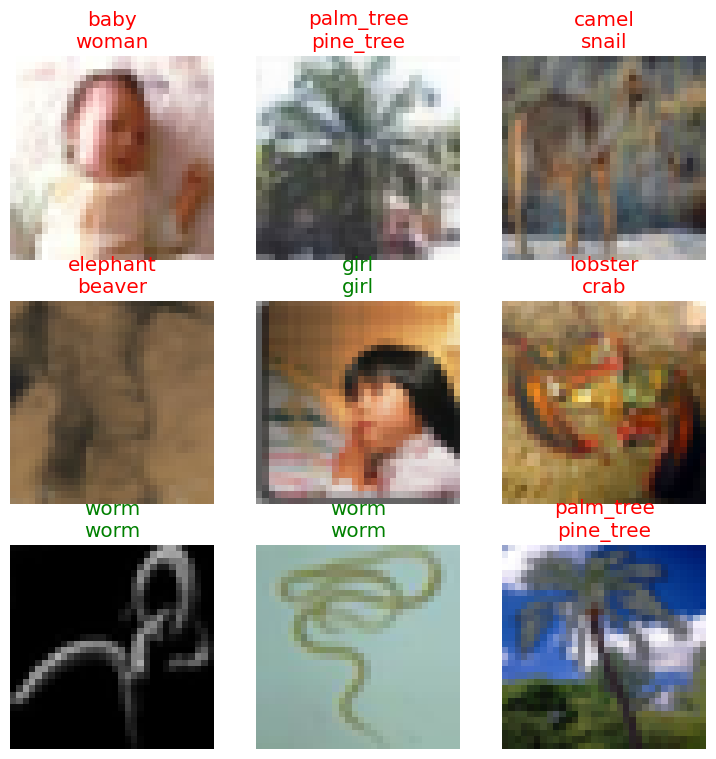

In [ ]:
# Objeto Learner
EarlyStopping_learn = Learner(dls, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = EarlyStopping_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
EarlyStopping_learn.fit_one_cycle(n_epoch = 30, lr_max = lr[0], cbs = EarlyStoppingCallback(patience = 3))    # Early Stopping

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
EarlyStopping_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = EarlyStopping_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(EarlyStopping_learn.recorder.values)):
  epoch_metrics_val = EarlyStopping_learn.recorder.values[i]  # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                       # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
EarlyStopping_learn.show_results()

# Mostrar todos los detalles del objeto Learner
EarlyStopping_learn.summary()

### **2.5.1. Análisis de los Resultados**

- Loss en Training: 2.169011

- Loss en Validation: 2.292956

- Accuracy en Validation: 0.283200

Al comparar estos resultados con los del ejercicio 1, se observa lo siguiente:

- El modelo con Early Stopping presenta una pérdida en el conjunto de entrenamiento más baja en la mayoría de las épocas, lo que sugiere una mejor convergencia y un mejor ajuste a los datos de entrenamiento.

- La pérdida en el conjunto de validación es menor en varias épocas para el modelo con Early Stopping, lo que indica una mejor capacidad de generalización a datos no vistos.

- El accuracy en el conjunto de validación es superior en el modelo con Early Stopping, lo que sugiere que este modelo es capaz de realizar predicciones más precisas sobre datos no utilizados durante el entrenamiento.

- Tal como se esperaba, la implementación de Early Stopping parece ayudar a reducir el sobreajuste, ya que la pérdida en el conjunto de entrenamiento es más baja en comparación con el modelo original en varias épocas.

## **2.6. Mejora 6: Data Augmentation**

La técnica de Data Augmentation es una estrategia utilizada en el entrenamiento de modelos de deep learning para mejorar la capacidad de generalización y reducir el sobreajuste. Consiste en aplicar transformaciones aleatorias y realistas a los datos de entrenamiento, generando nuevas muestras a partir de las originales. Estas transformaciones modifican la apariencia de las imágenes sin cambiar sus etiquetas de clase.

Algunas de las transformaciones comunes realizadas en Data Augmentation para imágenes incluyen:

1. **Rotación**: Girar la imagen en un ángulo aleatorio.
2. **Desplazamiento horizontal y vertical**: Mover la imagen hacia la derecha, izquierda, arriba o abajo.
3. **Zoom**: Aumentar o reducir el tamaño de la imagen.
4. **Inversión horizontal/vertical**: Reflejar la imagen horizontal o verticalmente.

Al aplicar esta técnica, se generan nuevas instancias de datos, ampliando el conjunto de entrenamiento y ayudando a evitar el sobreajuste al proporcionar al modelo una variedad más amplia de ejemplos. La variabilidad introducida permite que el modelo aprenda patrones más robustos y sea capaz de generalizar mejor a datos no vistos. Además, el modelo se vuelve invariante a ciertas transformaciones, como cambios en la orientación, posición o tamaño de los objetos.

En FastAI, para aplicar Data Augmentation, se utiliza la función `aug_transforms()`, que debe colocarse en el parámetro `batch_tfms` de la función `DataBlock()` al crear un Datablock o en la función `dataloaders()` al crear un Dataloader. Es posible modificar varios parámetros de `aug_transforms()`, como el mínimo y máximo de zoom, el grado máximo de rotación, entre otros.

En nuestro caso, hemos especificado el parámetro `mult = 2` (su valor por defecto es 1), que multiplica los valores de los parámetros `max_rotate`, `max_lightning` y `max_warp`.

Para más información, se puede consultar la siguiente documentación de FastAI:

[32] https://docs.fast.ai/vision.augment.html#aug_transforms

In [ ]:
#Definición del DataBlock
DataAug_CIFAR100db = DataBlock(
                      blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      splitter = RandomSplitter(valid_pct = 0.1, seed= 42),
                      get_y = parent_label
)

# Definición del DataLoad para el conjunto de datos de entrenamiento y el conjunto de datos de validación
DataAug_train_val_CIFAR100dl = DataAug_CIFAR100db.dataloaders(path/'train', bs = 32, batch_tfms = aug_transforms(mult = 2))  # Data Augmentation

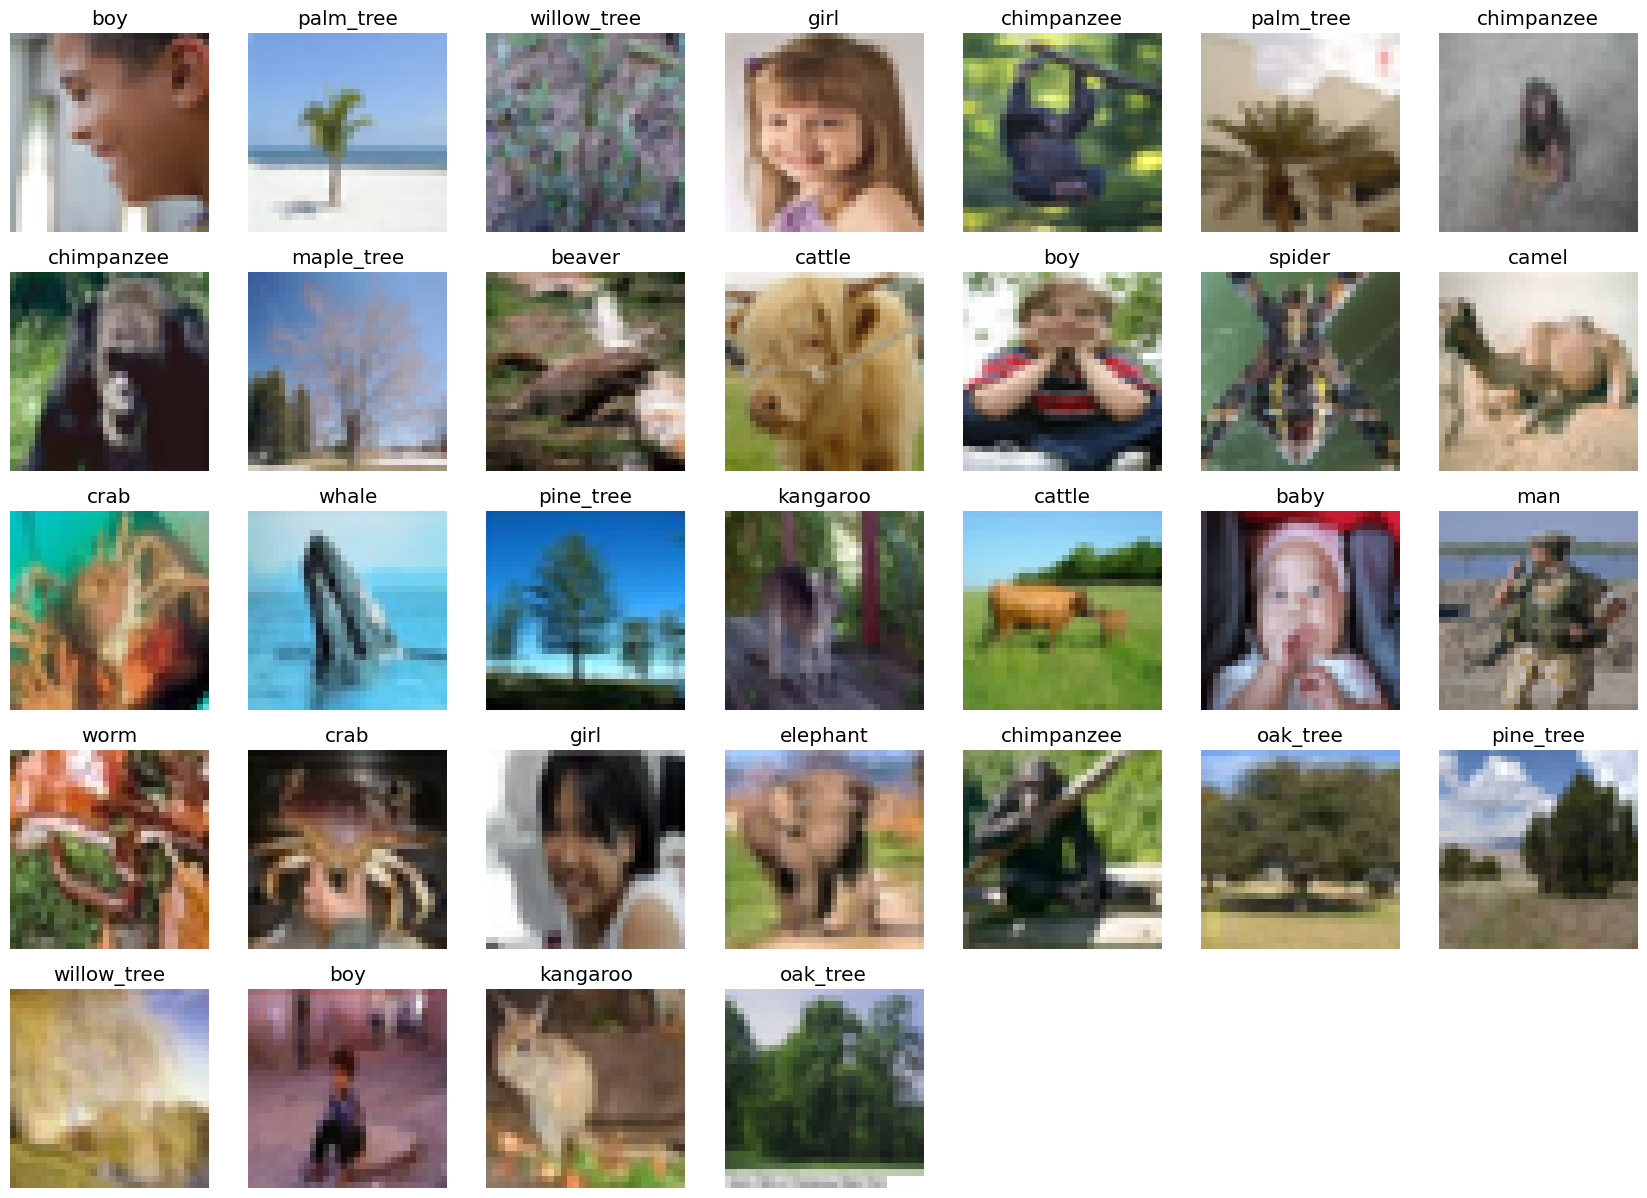

In [ ]:
# Muestra un batch de imágenes del conjunto de entrenamiento
DataAug_train_val_CIFAR100dl.train.show_batch(max_n = 32)

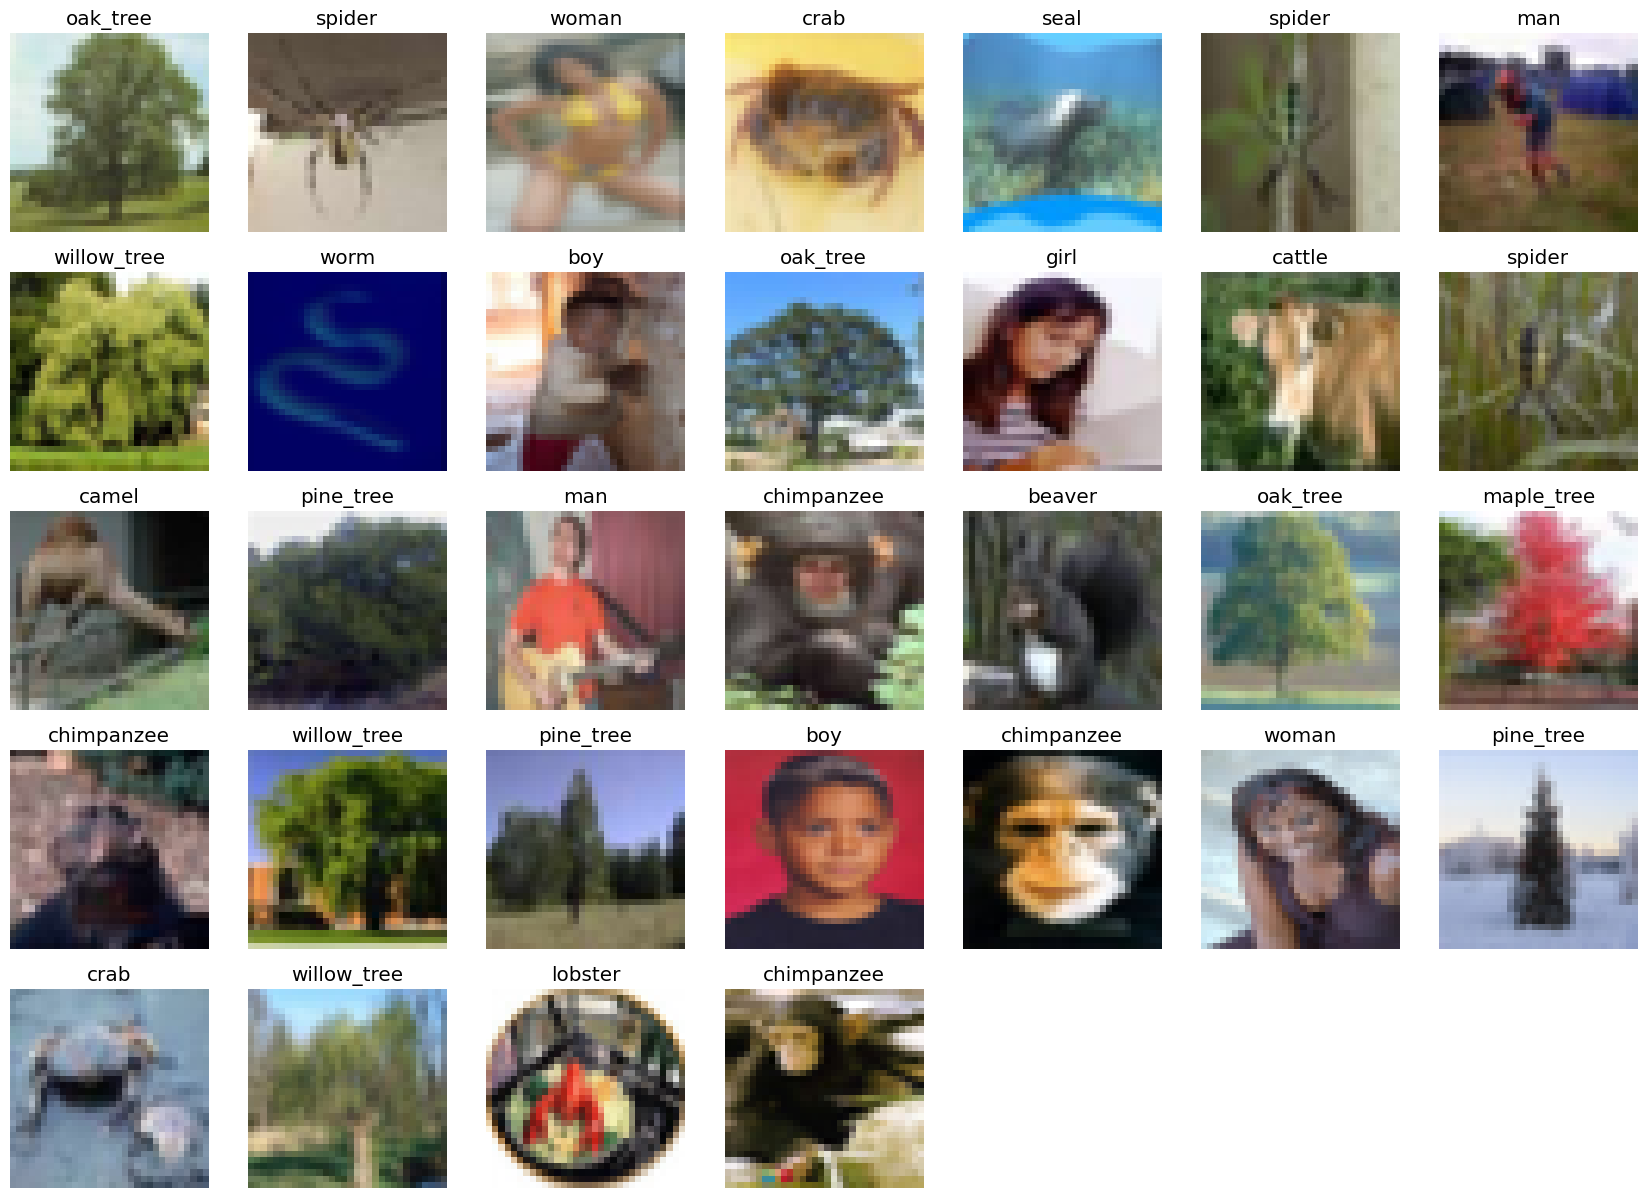

In [ ]:
# Muestra un batch de imágenes del conjunto de validación
DataAug_train_val_CIFAR100dl.valid.show_batch(max_n = 32)

Esta técnica de Data Augmentation se aplica únicamente al conjunto de entrenamiento, no al de validación ni al de test. Al mostrar un batch de imágenes del conjunto de entrenamiento, se puede observar que las transformaciones se aplican correctamente en algunas de las imágenes. Surgió la duda de si incluir `batch_tfms = aug_transforms()` en `DataAug_CIFAR100db.dataloaders()` también aplicaba las transformaciones al conjunto de validación (lo cual no debería suceder).

En un primer momento, al mostrar un batch de imágenes del conjunto de validación, parecía que las transformaciones no se aplicaban en este conjunto. Sin embargo, dado que las imágenes del dataset CIFAR100 son pequeñas (y por lo tanto, pueden ser borrosas), no estábamos completamente seguros. Por esta razón, se probó el mismo código con el dataset MNIST, y se corroboró que las transformaciones solo se aplican al conjunto de entrenamiento, excluyendo correctamente al conjunto de validación.

LEARNING RATE: 0.00019054606673307717 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

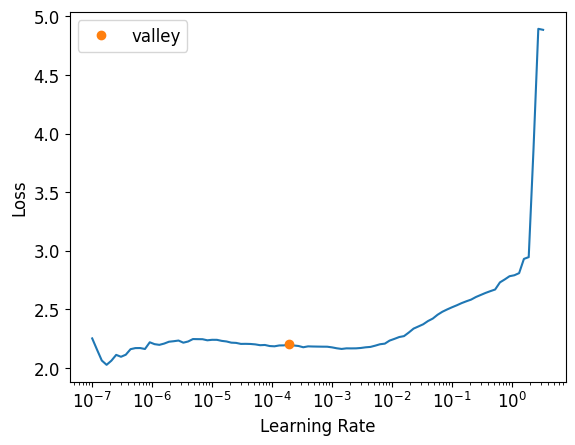

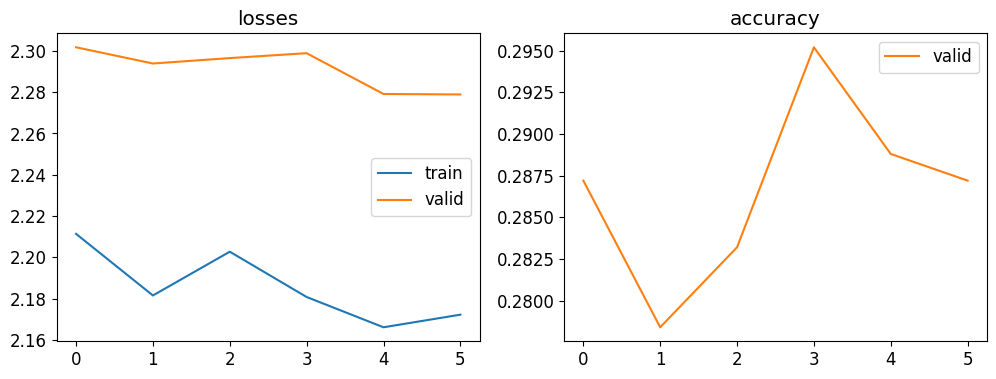


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  28.72 %

	ÉPOCA 1 :  27.84 %

	ÉPOCA 2 :  28.32 %

	ÉPOCA 3 :  29.52 %

	ÉPOCA 4 :  28.88 %

	ÉPOCA 5 :  28.72 %

ACCURACY en el conjunto VALIDATION:  28.72 %



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

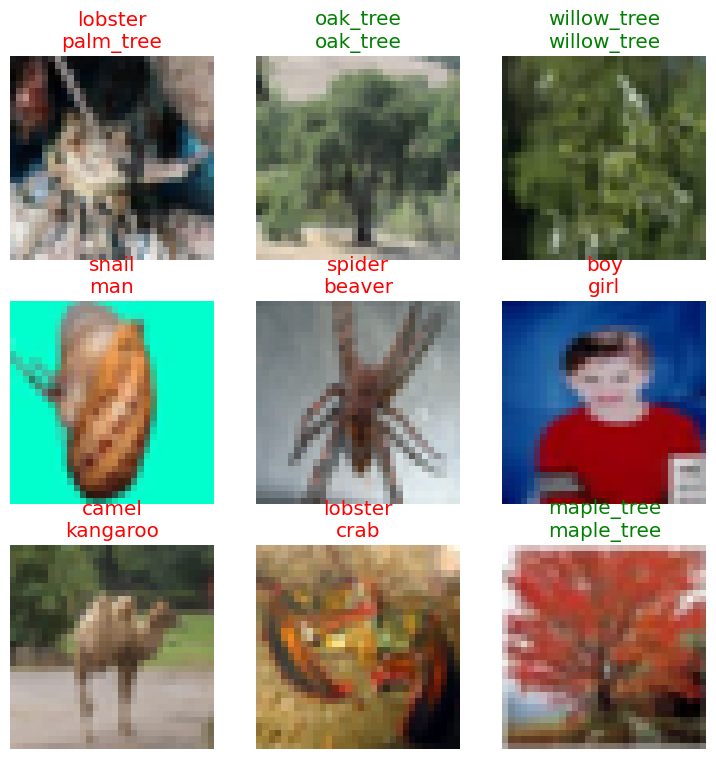

In [ ]:
# Objeto Learner
DataAug_learn = Learner(DataAug_train_val_CIFAR100dl, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = DataAug_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
DataAug_learn.fit_one_cycle(n_epoch = 6, lr_max = lr[0])

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
DataAug_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = DataAug_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(DataAug_learn.recorder.values)):
  epoch_metrics_val = DataAug_learn.recorder.values[i]  # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]                 # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
DataAug_learn.show_results()

# Mostrar todos los detalles del objeto Learner
DataAug_learn.summary()

- Loss en Training: 2.172207

- Loss en Validation: 2.278904

- Accuracy en Validation: 0.287200

Si comparamos estos resultados con los del ejercicio 1, se observa lo siguiente:

- El modelo con Data Augmentation muestra una tendencia a tener un mayor *loss* de entrenamiento en las primeras épocas, pero hacia el final, la diferencia con el modelo sin Data Augmentation se reduce.

- En varias épocas, el modelo con Data Augmentation presenta un ligero aumento en la pérdida en el conjunto de validación en comparación con el modelo sin la técnica. Esto podría indicar que Data Augmentation no ha mejorado significativamente la generalización en este caso.

- El modelo sin técnica aplicada tiene un *accuracy* más alto en el conjunto de validación en la mayoría de las épocas, lo que sugiere que podría estar generalizando mejor. Sin embargo, como se mencionó anteriormente, este no es el modelo final, sino una ilustración de cada una de las técnicas. El objetivo es combinar todas las técnicas para lograr una mejora significativa en el *accuracy* obtenido en el modelo del ejercicio 1.

- Data Augmentation ha contribuido a reducir la brecha entre el rendimiento en el conjunto de entrenamiento y el conjunto de validación, lo que sugiere una disminución en el sobreajuste.

## **2.7. Modelo Final**

Haciendo una combinación de todas las técnicas anteriores, construimos nuestro modelo final como se muestra a continuación. Cabe destacar que existen infinitos ajustes posibles y no hay una fórmula exacta para determinar la mejor configuración. Por lo tanto, hemos experimentado con diferentes valores de los hiperparámetros hasta llegar a una especificación que nos ofrece buenos resultados, así como ajustando el número de capas convolucionales a añadir. No obstante, siempre seguimos una lógica y una intuición basadas en las características de cada técnica y el comportamiento observado en las distintas iteraciones.

### **2.7.1. Preparación y Carga de Datos**

In [ ]:
# Transformaciones de Data Augmentation
tfms = aug_transforms(max_rotate = 20, max_zoom = 1.5, max_lighting = 0.5, max_warp = 0.1, p_affine = 0.5)

# Definición del Datablock
final_CIFAR100db = DataBlock(
                          blocks     = (ImageBlock, CategoryBlock),
                          get_items  = get_image_files,
                          splitter   = RandomSplitter(valid_pct = 0.1, seed = 42),
                          get_y      = parent_label,
                          item_tfms  = Resize(64),                                    # Redimensionamos las imágenes  de 32 x 32 a 64 x 64 píxeles
                          batch_tfms = [Normalize.from_stats(*cifar_stats), *tfms]    # Data Normalization y Data Augmentation
                      )

# Definición del DataLoad para el conjunto de datos de entrenamiento y el conjunto de datos de validación
dls_final = final_CIFAR100db.dataloaders(path/'train', bs = 32)

### **2.7.2. Definición del Modelo**

In [ ]:
final_baseNet = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = (3,3)),     # Capa 1: Convolución
    nn.BatchNorm2d(num_features = 64),                                      # Capa 2: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 3: Función de Activación ReLU
    nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3)),    # Capa 4: Convolución
    nn.BatchNorm2d(num_features = 64),                                      # Capa 5: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 6: Función de Activación Tanh
    nn.MaxPool2d(kernel_size = (2,2)),                                      # Capa 7: Agrupación Máxima (MaxPooling2D 2x2)
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3)),   # Capa 8: Convolución
    nn.BatchNorm2d(num_features = 128),                                     # Capa 9: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 10: Función de Activación ReLU
    nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3)),  # Capa 11: Convolución
    nn.BatchNorm2d(num_features = 128),                                     # Capa 12: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 13: Función de Activación ReLU
    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3)),  # Capa 14: Convolución
    nn.BatchNorm2d(num_features = 256),                                     # Capa 15: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 16: Función de Activación ReLU
    nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3)),  # Capa 17: Convolución
    nn.BatchNorm2d(num_features = 256),                                     # Capa 18: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 19: Función de Activación ReLU
    nn.MaxPool2d(kernel_size = (2,2)),                                      # Capa 20: Agrupación Máxima (MaxPooling2D 2x2)
    nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3,3)),  # Capa 21: Convolución
    nn.BatchNorm2d(num_features = 512),                                     # Capa 22: Batch Normalization después de la capa de convolución
    nn.ReLU(),                                                              # Capa 23: Función de Activación ReLU
    nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3)),  # Capa 24: Convolución
    nn.BatchNorm2d(num_features = 512),                                     # Capa 25: Batch Normalization después de la capa de convolución y la función de activación
    nn.ReLU(),                                                              # Capa 26: Función de Activación ReLU
    nn.MaxPool2d(kernel_size = (2,2)),                                      # Capa 27: Agrupación Máxima (MaxPooling2D 2x2)
    nn.Flatten(),                                                           # Capa 28: Pasar de tensor tridimensional a tensor unidimensional (vector 1D)
    nn.Linear(in_features = 4608, out_features = 512),                      # Capa 29: Fully-Connected
    nn.BatchNorm1d(num_features = 512),                                     # Capa 30: Batch Normalization después de la capa fully-connected
    nn.Dropout(p = 0.3),                                                    # Capa 31: Dropout con una tasa de 0.3
    nn.ReLU(),                                                              # Capa 32: Función de Activación ReLU
    nn.Linear(in_features = 512, out_features = 25),                        # Capa 33: Fully-Connected (25 clases de salida)
)

Al igual que hicimos en el ejercicio 1, vamos a calcular el número total de parámetros de nuestro modelo, para lo cual necesitamos sumar el número de parámetros en cada capa.

Recordemos que la fórmula general para calcular el número de parámetros en una capa convolucional es:

$$ \text{Número de parámetros} = (\text{Tamaño del kernel} ⋅ \text{Número de canales de entrada} + 1\ \text{(en caso de haber bias)}) ⋅ \text{Número de canales de salida}$$

También calcularemos el volumen de salida de cada capa convolucional, el cual se calcula mediante la fórmula:

$$ \text{Tamaño de salida} = \left( \frac{N + 2 \cdot P - F}{\text{stride}} \right) + 1 $$

donde:

- $\text{Tamaño de salida}$: Tamaño de la salida de la capa convolucional. Representa las dimensiones (altura y ancho) del volumen resultante después de aplicar la operación de convolución.

- $N$: Tamaño de la entrada (input volume). En el contexto de la capa convolucional, esto se refiere al tamaño de la imagen de entrada.

- $P$: Es el tamaño del relleno (padding). Como ya se explicó anteriormente, el relleno se agrega a la entrada antes de aplicar la convolución y este ayuda a mantener el tamaño de la salida. Puede ser útil para evitar la pérdida de información en los bordes de la imagen.

- $F$: Altura/Anchura (son iguales) del filtro/kernel.

- $stride$: Es el tamaño del paso (stride). Como ya se explicó anteriormente, este indica la cantidad de píxeles que el filtro se desplaza en cada paso durante la convolución.

Recordemos también la fórmula general para calcular el número de parámetros en una capa fully-connected:

$$ \text{Número de parámetros} = (\text{in_features} + 1\ \text{(en caso de haber bias)}) ⋅ \text{out_features}$$

donde:

- $\text{in_features}$: Número de neuronas en la entrada de la capa.
- $\text{out_features}$: Número de neuronas en la salida de la capa.

Ahora tenemos también capas de Batch Normalization, la cual tiene dos conjuntos de parámetros: uno para la escala (weight) y otro para el sesgo (bias). Así, la fórmula general para calcular el número de parámetros en una capa de Batch Normalization con num_features características es:

$$\text{Número de parámetros} = 2 ⋅ \text{num_features}$$


Hay que tener en cuenta que redimensionamos las dimensiones de las imágenes de entrada iniciales, pasando de 32 x 32 píxeles a 64 x 64 píxeles. Vamos a desglosar la cuenta para cada capa del modelo:

1. Primera capa convolucional:
  - Volumen de entrada: 64 x 64 x 3 ($N = 64$).
  - Filtros/Kernels usados: 64 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (64 + 2 * 0 - 3) / 1 + 1 = 62 --> 62 x 62 x 64
  - Número de parámetros: Cada filtro tiene 3 * 3 * 3 + 1 = 28 parámetros --> La capa tiene 28 * 64 = 1792 parámetros.

2. Primera capa de Batch Normalization:
  - num_features: 64.
  - Número de parámetros: 2 * 64 = 128

3. Primera capa de activación ReLU: No se calculan parámetros.

4. Segunda capa convolucional:
  - Volumen de entrada: 62 x 62 x 64 ($N = 62$).
  - Filtros/Kernels usados: 64 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (62 + 2 * 0 - 3) / 1 + 1 = 60 --> 60 x 60 x 64
  - Número de parámetros: Cada filtro tiene 3 * 3 * 64 + 1 = 577 parámetros --> La capa tiene 577 * 64 = 36 928 parámetros.

5. Segunda capa de Batch Normalization:
  - num_features: 64.
  - Número de parámetros: 2 * 64 = 128

6. Segunda capa de activación ReLU: No se calculan parámetros.

7. Primera capa de Max Pooling: No se calculan parámetros (pero, al aplicarse un filtro 2 x 2, reduce a la mitad las dimensiones del volumen de salida de la anterior capa convolucional. Es decir, si el volumen de salida era de 60 x 60 x 64, ahora pasa a ser de 30 x 30 x 64).

8. Tercera capa convolucional:
  - Volumen de entrada: 30 x 30 x 64 ($N = 30$).
  - Filtros/Kernels usados: 128 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (30 + 2 * 0 - 3) / 1 + 1 = 28 --> 28 x 28 x 128
  - Número de parámetros: Cada filtro tiene 3 * 3 * 64 + 1 = 577 parámetros --> La capa tiene 577 * 128 = 73 856 parámetros.

9. Tercera capa de Batch Normalization:
  - num_features: 128.
  - Número de parámetros: 2 * 128 = 256

10. Tercera capa de activación ReLU: No se calculan parámetros.

11. Cuarta capa convolucional:
  - Volumen de entrada: 28 x 28 x 128 ($N = 28$).
  - Filtros/Kernels usados: 128 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (28 + 2 * 0 - 3) / 1 + 1 = 26 --> 26 x 26 x 128
  - Número de parámetros: Cada filtro tiene 3 * 3 * 128 + 1 = 1153 parámetros --> La capa tiene 1153 * 128 = 147 584 parámetros.

12. Cuarta capa de Batch Normalization:
  - num_features: 128.
  - Número de parámetros: 2 * 128 = 256

13. Cuarta capa de activación ReLU: No se calculan parámetros.

14. Quinta capa convolucional:
  - Volumen de entrada: 26 x 26 x 128 ($N = 26$).
  - Filtros/Kernels usados: 256 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (26 + 2 * 0 - 3) / 1 + 1 = 24 --> 24 x 24 x 256
  - Número de parámetros: Cada filtro tiene 3 * 3 * 128 + 1 = 1153 parámetros --> La capa tiene 1153 * 256 = 295 168 parámetros.

15. Quinta capa de Batch Normalization:
  - num_features: 256.
  - Número de parámetros: 2 * 256 = 512

16. Quinta capa de activación ReLU: No se calculan parámetros.

17. Sexta capa convolucional:
  - Volumen de entrada: 24 x 24 x 256 ($N = 24$).
  - Filtros/Kernels usados: 256 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (24 + 2 * 0 - 3) / 1 + 1 = 22 --> 22 x 22 x 256
  - Número de parámetros: Cada filtro tiene 3 * 3 * 256 + 1 = 2305 parámetros --> La capa tiene 2305 * 256 = 590 080 parámetros.

18. Sexta capa de Batch Normalization:
  - num_features: 256.
  - Número de parámetros: 2 * 256 = 512

19. Sexta capa de activación ReLU: No se calculan parámetros.

20. Segunda capa de Max Pooling: No se calculan parámetros (pero, al aplicarse un filtro 2 x 2, reduce a la mitad las dimensiones del volumen de salida de la anterior capa convolucional. Es decir, si el volumen de salida era de 22 x 22 x 256, ahora pasa a ser de 11 x 11 x 256).

21. Séptima capa convolucional:
  - Volumen de entrada: 11 x 11 x 256 ($N = 11$).
  - Filtros/Kernels usados: 512 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (11 + 2 * 0 - 3) / 1 + 1 = 9 --> 9 x 9 x 512
  - Número de parámetros: Cada filtro tiene 3 * 3 * 256 + 1 = 2305 parámetros --> La capa tiene 2305 * 512 = 1 180 160 parámetros.

22. Séptima capa de Batch Normalization:
  - num_features: 512.
  - Número de parámetros: 2 * 512 = 1024

23. Séptima capa de activación ReLU: No se calculan parámetros.

24. Octava capa convolucional:
  - Volumen de entrada: 9 x 9 x 512 ($N = 9$).
  - Filtros/Kernels usados: 512 de 3 x 3 con stride 1 y padding 0 ($F = 3, P = 0, stride = 1$).
  - Volumen de salida: (9 + 2 * 0 - 3) / 1 + 1 = 7 --> 7 x 7 x 512
  - Número de parámetros: Cada filtro tiene 3 * 3 * 512 + 1 = 4609 parámetros --> La capa tiene 409 * 512 = 2 359 808 parámetros.
  
25. Octava capa de Batch Normalization:
  - num_features: 512.
  - Número de parámetros: 2 * 512 = 1024

26. Octava capa de activación ReLU: No se calculan parámetros.

27. Tercera capa de Max Pooling: No se calculan parámetros (pero, al aplicarse un filtro 2 x 2, reduce a la mitad las dimensiones del volumen de salida de la anterior capa convolucional. Es decir, si el volumen de salida era de 7 x 7 x 512, ahora pasa a ser de 3 x 3 x 512).

28. Capa de aplanamiento (Flatten): No se calculan parámetros.

29. Primera capa fully-connected:
  - Número de neuronas en la entrada: 4608 (= 3 * 3 * 512, resultado de aplicar flatten al volumen de salida de la octava capa convolucional tras el max pooling 2 x 2).
  - Número de neuronas en la salida: 512.
  - Número de parámetros: (4608 + 1) * 512 = 2 359 808

30. Novena capa de Batch Normalization:
  - num_features: 512.
  - Número de parámetros: 2 * 512 = 1024

31. Capa de Dropout: No se calculan parámetros.

32. Novena capa de activación ReLU: No se calculan parámetros.

33. Segunda capa fully-connected:
  - Número de neuronas en la entrada: 512 (número de neuronas en la salida de la primera capa fully-connected).
  - Número de neuronas en la salida: 25.
  - Número de parámetros: (512 + 1) * 25 = 12 825

34. Capa de activación Softmax (no se incluye explícitamente en el modelo, pero se encuentra internamente. Véase la respuesta a la segunda pregunta del primer ejercicio): No se calculan parámetros.

Ahora, sumamos el número de parámetros de todas las capas:

$$1792 + 128 + 0 + 36\ 928 + 128 + 0 + 0 + 73\ 856 + 256 + 0 + 147\ 584 + 256 + 0 + 295\ 168 + 512 + 0 + 590\ 080 + 512 + 0 + 0 + 1\ 180\ 160 + 1024 + 0 + 2\ 359\ 808 + 1024 + 0 + 0 + 0 + 2\ 359\ 808 + 1024 + 0 + 0 + 12\ 825 + 0 = 7\ 062\ 873$$

En conclusión:

$$ \text{Número total de parámetros del modelo} = 7\ 062\ 873, $$

### **2.7.3. Entrenamiento y Validación del Modelo**

LEARNING RATE: 0.00013182566908653826 



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

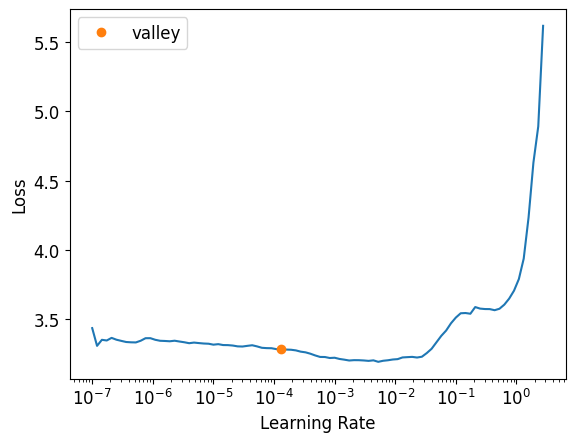

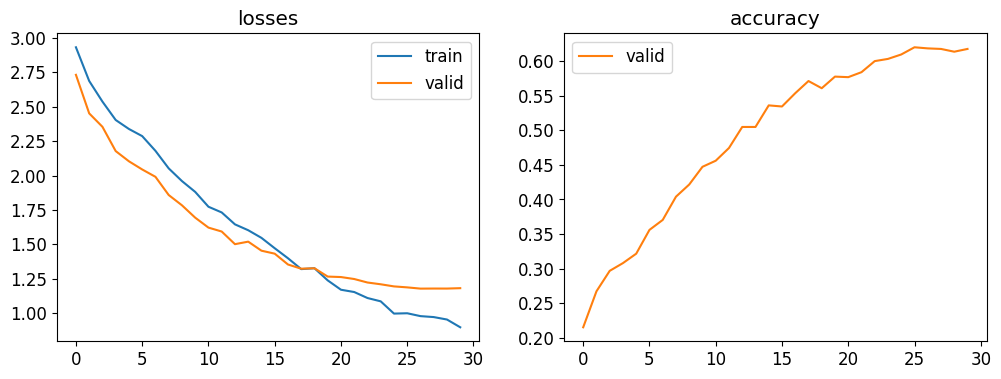


ACCURACY POR ÉPOCA en el conjunto VALIDATION:

	ÉPOCA 0 :  21.52 %

	ÉPOCA 1 :  26.72 %

	ÉPOCA 2 :  29.68 %

	ÉPOCA 3 :  30.8 %

	ÉPOCA 4 :  32.16 %

	ÉPOCA 5 :  35.6 %

	ÉPOCA 6 :  37.04 %

	ÉPOCA 7 :  40.4 %

	ÉPOCA 8 :  42.16 %

	ÉPOCA 9 :  44.72 %

	ÉPOCA 10 :  45.6 %

	ÉPOCA 11 :  47.44 %

	ÉPOCA 12 :  50.48 %

	ÉPOCA 13 :  50.48 %

	ÉPOCA 14 :  53.6 %

	ÉPOCA 15 :  53.44 %

	ÉPOCA 16 :  55.36 %

	ÉPOCA 17 :  57.12 %

	ÉPOCA 18 :  56.08 %

	ÉPOCA 19 :  57.76 %

	ÉPOCA 20 :  57.68 %

	ÉPOCA 21 :  58.4 %

	ÉPOCA 22 :  60.0 %

	ÉPOCA 23 :  60.32 %

	ÉPOCA 24 :  60.96 %

	ÉPOCA 25 :  62.0 %

	ÉPOCA 26 :  61.84 %

	ÉPOCA 27 :  61.76 %

	ÉPOCA 28 :  61.36 %

	ÉPOCA 29 :  61.76 %

ACCURACY en el conjunto VALIDATION:  61.76 %



Sequential (Input shape: 32 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 62 x 62   
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 30 x 30   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 28 x 28  
Conv2d                                    7385

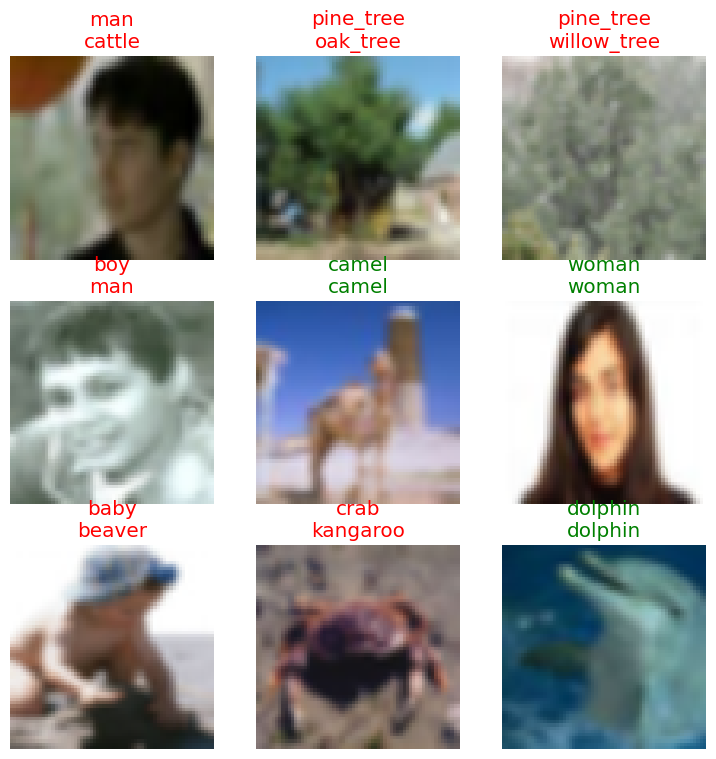

In [ ]:
# Objeto Learner
final_learn = Learner(dls_final, final_baseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# Encontrar el valor óptimo del learning rate (lr)
lr = final_learn.lr_find()
print(f'LEARNING RATE: {lr[0]} \n')

# Ejecutar el optimizador one-cycle
final_learn.fit_one_cycle(n_epoch = 30, lr_max = lr[0], cbs = EarlyStoppingCallback(patience = 5))    # Early Stopping

# Mostrar la curva de accuracy en validación a lo largo de las diferentes épocas
final_learn.recorder.plot_metrics()

# Accuracy en el conjunto de validación
final_metrics_val = final_learn.recorder.values[-1] # Últimos valores de las métricas almacenados en el historial

print('\nACCURACY POR ÉPOCA en el conjunto VALIDATION:')
for i in range(len(final_learn.recorder.values)):
  epoch_metrics_val = final_learn.recorder.values[i]  # Valores de las métricas en la época correspondiente
  epoch_acc_val = epoch_metrics_val[-1]               # Accuracy en validación en la época correspondiente
  print('\n\tÉPOCA', i, ': ', round(float(epoch_acc_val) * 100, 4), '%')

final_acc_val = final_metrics_val[-1]                    # Accuracy en validación de la última época de entrenamiento

print('\nACCURACY en el conjunto VALIDATION: ', round(float(final_acc_val) * 100, 4), '%\n')

# Mostrar resultados tras el entrenamiento del modelo
final_learn.show_results()

# Mostrar todos los detalles del objeto Learner
final_learn.summary()

Observamos que, tal y como se esperaba, los números del volumen de salida y los números de parámetros de cada capa (y del modelo completo) proporcionados por la función `learn.summary()`, coinciden con los números que hemos calculado anteriormente para nuestro modelo. Podemos ver que la nueva arquitectura tiene aproximadamente 7 millones de parámetros, lo que representa una diferencia bastante grande con respecto a la arquitectura inicial, que tenía aproximadamente 40,000 parámetros. Sin embargo, veremos más adelante que, al comparar los resultados, este aumento en el número de parámetros compensa enormemente. Además, el incremento en el tiempo de ejecución de cada época en este nuevo modelo tampoco es muy elevado.

### **2.7.4. Predicciones y Matriz de Confusión**

In [ ]:
# Generación de predicciones del modelo entrenado en el conjunto de entrenamiento
preds, targs, _ = final_learn.get_preds(dl = dls_final.train, with_decoded = True)

# Accuracy en el conjunto de entrenamiento
acc_train = accuracy(preds, targs)
print('\nACCURACY en el conjunto TRAINING: ', round(float(acc_train) * 100, 4), '%')


ACCURACY en el conjunto TRAINING:  73.4667 %



Número de ejemplos de training: 11250



ACCURACY en el conjunto TRAINING:  73.5644 %


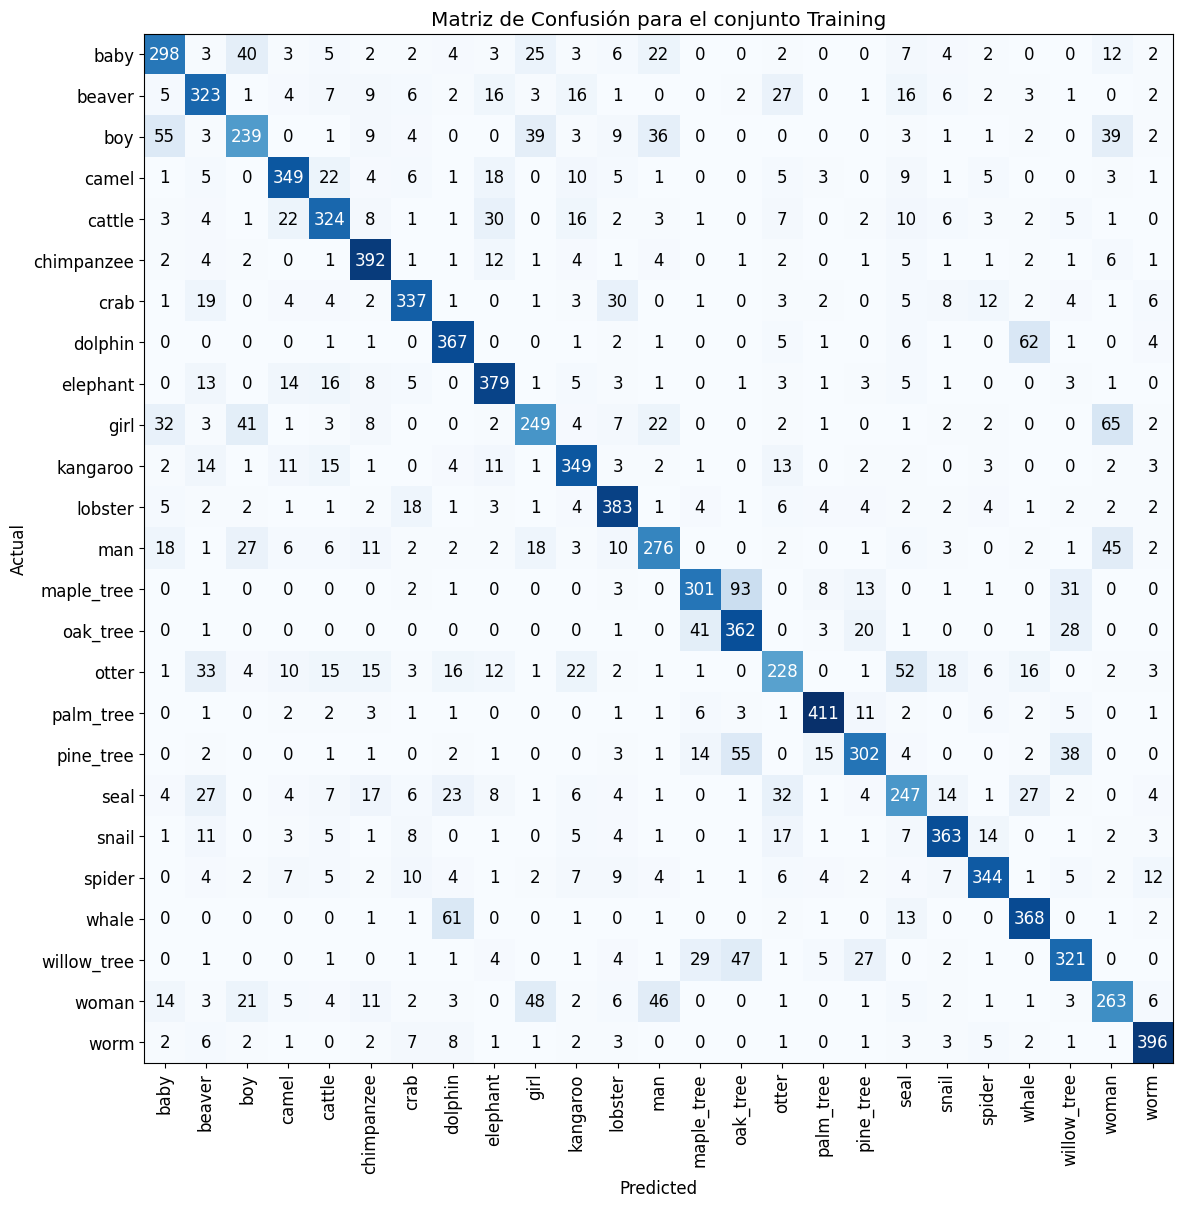

In [ ]:
# Matriz de confusión del conjunto de entrenamiento
interp_train = ClassificationInterpretation.from_learner(final_learn, 0, dls_final.train)
cm_train = interp_train.confusion_matrix()

print('\nNúmero de ejemplos de training:', np.sum(cm_train))
interp_train.plot_confusion_matrix(figsize = (12, 12), title = 'Matriz de Confusión para el conjunto Training')
print('\nACCURACY en el conjunto TRAINING: ', round(np.sum(np.diagonal(cm_train)) / np.sum(cm_train) * 100, 4), '%')

Podemos observar una diferencia bastante grande con respecto a la matriz de confusión de la arquitectura original. Recordemos que la matriz de confusión del ejercicio 1 tenía zonas oscuras fuera de la diagonal, mientras que la matriz de confusión de este modelo final, aunque aún presenta algunos fallos, muestra una tendencia mucho más clara hacia una matriz diagonal. Además, la diagonal de esta matriz final es considerablemente más oscura que el resto, lo que indica una mejora significativa en la clasificación.

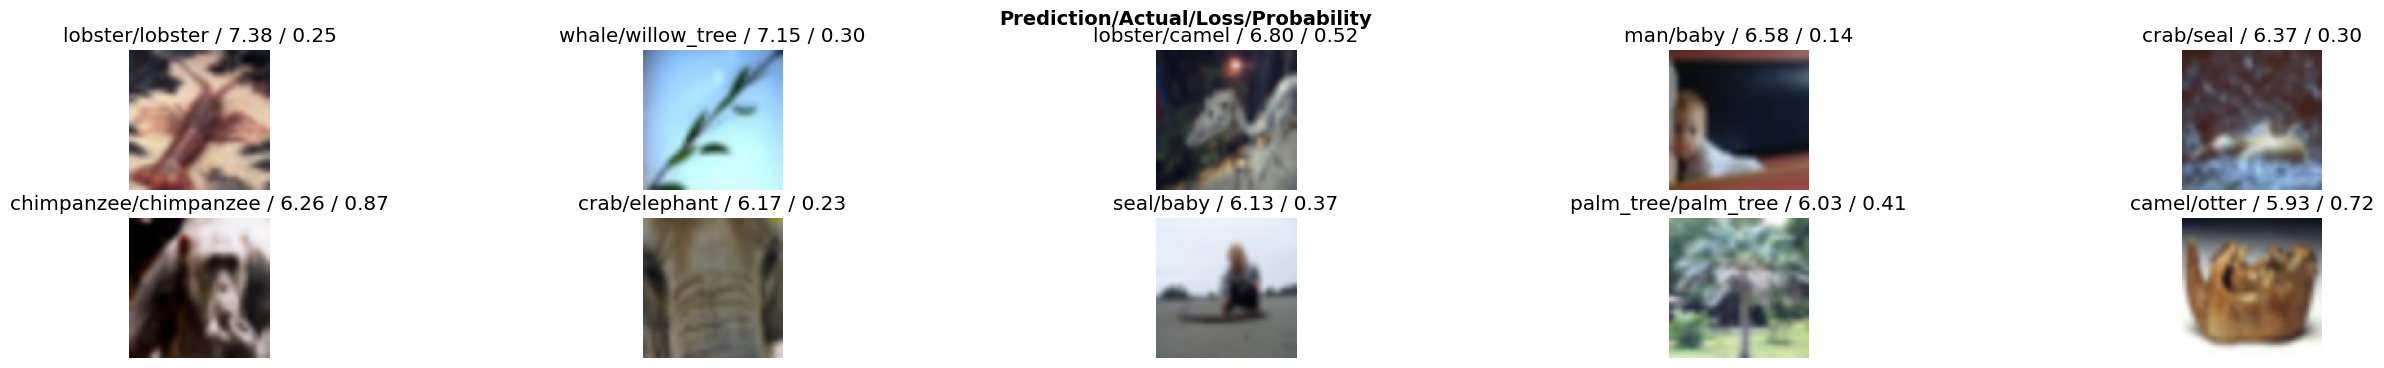

In [ ]:
# Mostrar las 10 clases del conjunto de entrenamiento con el mayor nivel de confusión
interp_train.plot_top_losses(10, nrows = 2, figsize = (32,4))

La discrepancia en los valores de accuracy en el conjunto de entrenamiento entre los dos bloques de código (uno a partir de las predicciones y otro mediante la matriz de confusión) podría deberse a pequeñas diferencias en la implementación interna de las funciones de FastAI al calcular el accuracy, en comparación con el cálculo realizado en el segundo bloque a través de la matriz de confusión. Además, es posible que los resultados difieran ligeramente debido a redondeos y a la representación numérica de los valores.

In [ ]:
# Definición del DataLoad para el conjunto de datos de prueba (test)
final_test_CIFAR100dl = final_learn.dls.test_dl(files_test, with_labels = True)

# Generación de predicciones del modelo entrenado en el conjunto de test
preds, targs, _ = final_learn.get_preds(dl = final_test_CIFAR100dl, with_decoded = True)

# Accuracy en el conjunto de test
acc_test = accuracy(preds, targs)
print('\nACCURACY en el conjunto TEST: ', round(float(acc_test) * 100, 4), '%')


ACCURACY en el conjunto TEST:  62.24 %



Número de ejemplos de test: 2500



ACCURACY en el conjunto TEST:  62.24 %


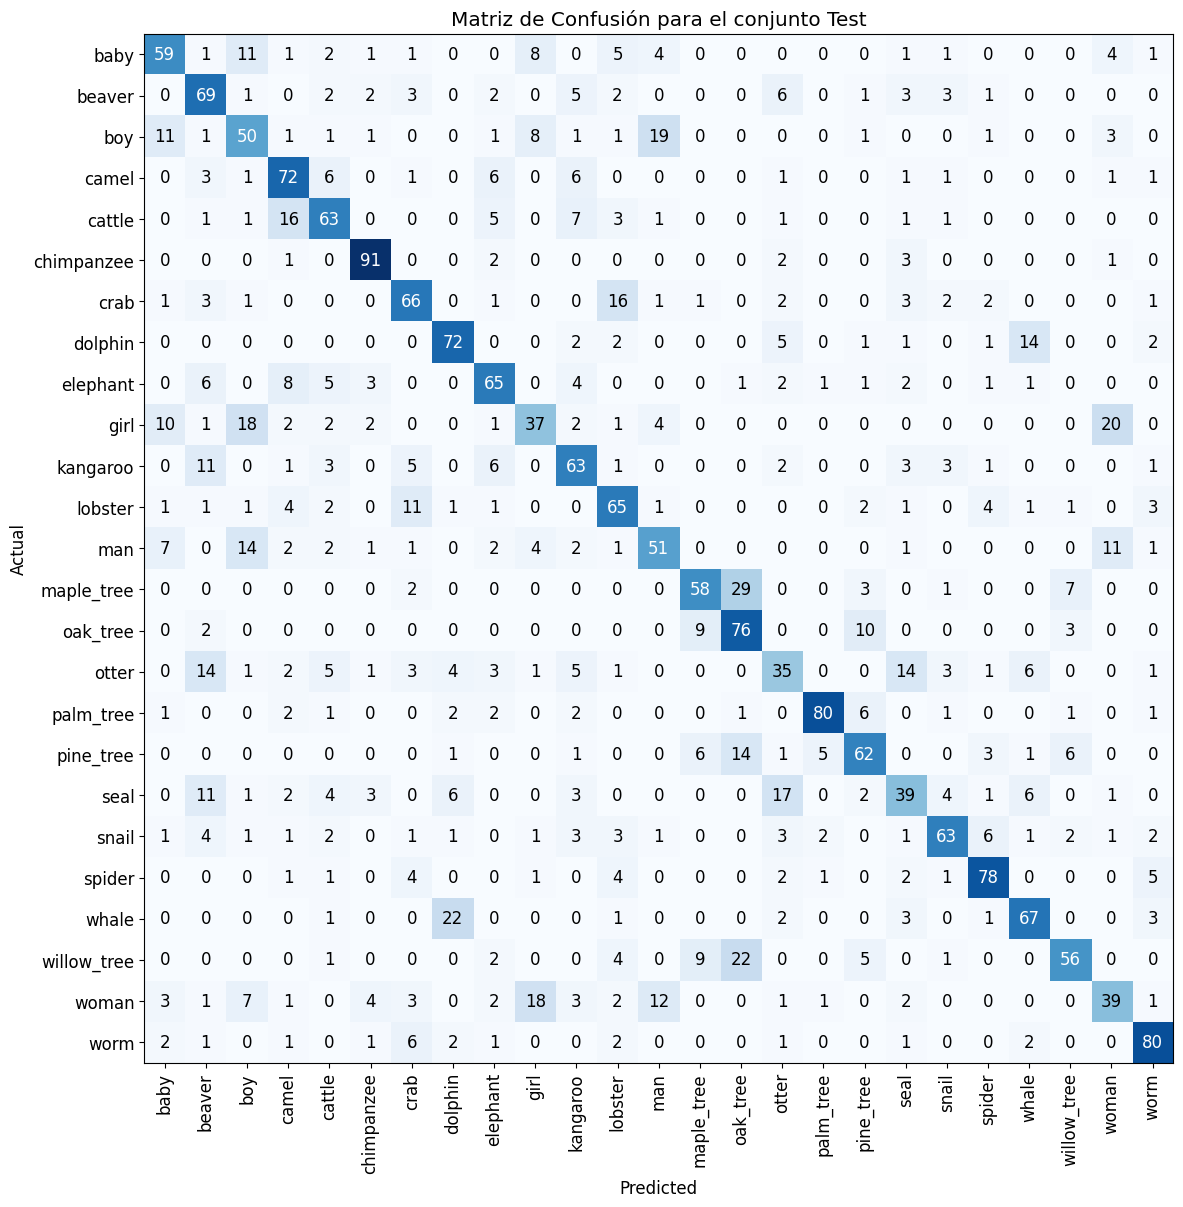

In [ ]:
# Matriz de confusión del conjunto de test
interp_test = ClassificationInterpretation.from_learner(final_learn, 1, final_test_CIFAR100dl)
cm_test = interp_test.confusion_matrix()

print('\nNúmero de ejemplos de test:', np.sum(cm_test))
interp_test.plot_confusion_matrix(figsize = (12, 12), title = 'Matriz de Confusión para el conjunto Test')
print('\nACCURACY en el conjunto TEST: ', round(np.sum(np.diagonal(cm_test)) / np.sum(cm_test) * 100, 4), '%')

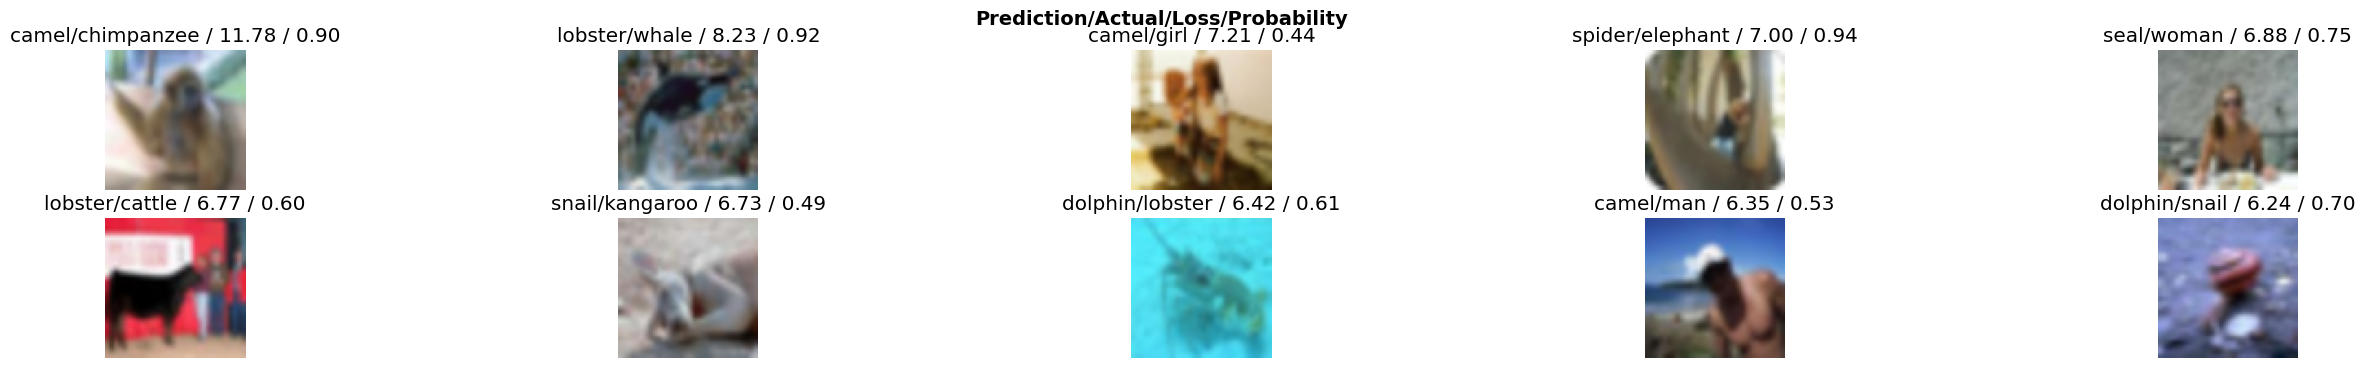

In [ ]:
# Mostrar las 10 clases del conjunto de test con el mayor nivel de confusión
interp_test.plot_top_losses(10, nrows = 2, figsize = (32,4))

### **2.7.5. Análisis de los Resultados**

Los resultados obtenidos por el modelo final son los siguientes:

- Loss en Training: 0.898045

- Accuracy en Training: 0.735644

- Loss en Validation: 1.182099

- Accuracy en Validation: 0.617600

- Accuracy en Test: 0.6224

Recordemos los resultados obtenidos por el modelo del ejercicio 1:

- Loss en Training: 3.163957

- Accuracy en Training: 0.079200

- Loss en Validation: 3.164734

- Accuracy en Validation: 0.0792

- Accuracy en Test: 0.0784

Si comparamos ambos modelos:

- El modelo mejorado muestra un aumento significativo (casi 6 veces) en el accuracy del conjunto de validación. Mientras que el modelo original tenía un accuracy final del 7%, el modelo final ha logrado alcanzar un 61.7%.

- En ambos modelos, el loss en los conjuntos de entrenamiento y validación disminuye considerablemente a lo largo de las épocas, lo que indica una buena capacidad de los modelos para aprender y generalizar. Sin embargo, esta capacidad es superior en el modelo final, ya que la brecha entre el loss de entrenamiento y el loss de validación parece haberse reducido, lo que sugiere una mejora en la generalización. Así, se ha logrado reducir el sobreajuste (overfitting) en el modelo final, mejorando su capacidad para generalizar.

En conclusión, como se esperaba, los resultados sugieren que las técnicas aplicadas han tenido un impacto positivo en la capacidad del modelo para aprender y generalizar. El aumento significativo en el accuracy en el conjunto de validación y la reducción del sobreajuste (overfitting) son indicativos de una mejora en el rendimiento global del modelo.